# *Importing CSV Files*

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import seaborn as sns
from utils import countInversions, countSwapPairs, countVertices, getLinearExtensions, preprocess

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)

In [2]:
csv = {}
keywords = ['algo1', 'algo2', 'algo2i', 'optsol']
for keyword in keywords:
    for vc in range(3, 7):
        if vc <= 4:
            csv[f'{keyword}_{vc}v'] = pd.read_csv(f'results/{vc}v{keyword}.csv')
        csv[f'{keyword}_{vc}v_trees'] = pd.read_csv(f'results/{vc}v{keyword}trees.csv')

In [3]:
keywords = ['algo1', 'algo2', 'algo2i', 'optsol']
for keyword in keywords:
    dimensions = []
    for vc in range(3, 7):
        if vc <= 4:
            dimensions.append(csv[f'{keyword}_{vc}v'].shape)
        dimensions.append(csv[f'{keyword}_{vc}v_trees'].shape)
    
    print(dimensions)

[(63, 4), (12, 4), (2149, 4), (128, 4), (2000, 4), (41472, 4)]
[(63, 4), (12, 4), (2149, 4), (128, 4), (2000, 4), (41472, 4)]
[(63, 4), (12, 4), (2149, 4), (128, 4), (2000, 4), (41472, 4)]
[(63, 4), (12, 4), (2149, 4), (128, 4), (2000, 4), (41472, 4)]


# *Defining Functions*

In [4]:
def merge(dataframes, joins):
    main = pd.merge(dataframes[0], dataframes[1], how=joins[0])
    for i in range(2, len(dataframes)):
        main = pd.merge(main, dataframes[i], how=joins[i - 1])
    
    return main

def extend(dataframe, keywords=['algo1', 'algo2', 'algo2i', 'optsol']):
    dataframe['input_size'] = dataframe['input'].map(lambda x: x.count('-') + 1)
    dataframe['vertex_count'] = dataframe['input'].map(lambda x: x.split('-')[0].count(',') + 1)
    dataframe['num_inversion'] = dataframe['input'].map(lambda x: countInversions(x))
    dataframe['num_swap_pair'] = dataframe['input'].map(lambda x: countSwapPairs(x))
    
    for keyword in keywords:
        dataframe[f'output_{keyword}'] = dataframe[f'output_{keyword}'].map(lambda x: 
                                                                            preprocess(str(x), False, False, True))
        
        dataframe[f'num_rel_{keyword}'] = dataframe[f'output_{keyword}'].map(lambda x: str(x).count('('))
        dataframe[f'lin_ext_{keyword}'] = dataframe.apply(lambda x:
                                                          getLinearExtensions(countVertices(x['input']),
                                                                              x[f'output_{keyword}'],
                                                                              True),
                                                          axis=1)
        dataframe[f'num_lin_ext_{keyword}'] = dataframe[f'lin_ext_{keyword}'].map(lambda x: [len(y) for y in x])
        dataframe[f'min_lin_ext_{keyword}'] = dataframe[f'num_lin_ext_{keyword}'].map(lambda x: min(x))
        dataframe[f'max_lin_ext_{keyword}'] = dataframe[f'num_lin_ext_{keyword}'].map(lambda x: max(x))
        if keyword != 'optsol':
            dataframe[f'approx_{keyword}'] = dataframe.apply(lambda x: 
                                                             x[f'cost_{keyword}']/x[f'cost_optsol'], axis=1)
            dataframe[f'cost_diff_{keyword}'] = dataframe.apply(lambda x: 
                                                                abs(x[f'cost_{keyword}'] - x['cost_optsol']), axis=1)
            
def extendMore(dataframe, keywords=['algo1', 'algo2', 'algo2i']):
    for keyword in keywords:
        dataframe[f'is_opt_{keyword}'] = dataframe[f'cost_diff_{keyword}'] == 0

In [5]:
def getApproxVsVal(dataframe, algorithm, attribute, value, operator='eq'):
    column = f'{attribute}_{algorithm}'
    if operator == 'eq':
        approx = dataframe[dataframe[column] == value]
    elif operator == 'neq':
        approx = dataframe[dataframe[column] != value]
    elif operator == 'gt':
        approx = dataframe[dataframe[column] > value]
    elif operator == 'lt':
        approx = dataframe[dataframe[column] < value]
    
    return approx

def getApproxVsApprox(dataframe, algorithm1, algorithm2, attribute, operator='eq'):
    column1 = f'{attribute}_{algorithm1}'
    column2 = f'{attribute}_{algorithm2}'
    if operator == 'eq':
        approx = dataframe[dataframe[column1] == dataframe[column2]]
    if operator == 'neq':
        approx = dataframe[dataframe[column1] != dataframe[column2]]
    if operator == 'gt':
        approx = dataframe[dataframe[column1] > dataframe[column2]]
    if operator == 'lt':
        approx = dataframe[dataframe[column1] < dataframe[column2]]
    
    return approx

In [20]:
def getLabel(attribute):
    x_attributes = ['input_size', 'vertex_count', 'num_inversion', 'num_swap_pair']
    x_labels = ['Number of linear orders', 'Number of vertices', 
                'Number of inversions', 'Number of swap pairs']
    y_attributes = ['runtime', 'cost', 'num_rel', 'min_lin_ext', 'max_lin_ext']
    y_labels = ['Time elapsed generating', 'Cost of', 'Number of binary relations in', 
                'Lowest number of linear extensions in',
                'Highest number of linear extensions in']
    
    if attribute in x_attributes:
        return x_labels[x_attributes.index(attribute)]
    for y_attribute in y_attributes:
        if y_attribute in attribute:
            algo = attribute.split(y_attribute)[1][1:]
            if algo == 'optsol':
                y_text = 'optimal solution'
            else:
                y_text = 'approximation of Algorithm ' + str(algo[4:])
            return y_labels[y_attributes.index(y_attribute)] + ' ' + y_text

def plotScatters(dataframe, columns, identifier):
    analysis = dataframe[columns]
    fig, axs = plt.subplots(nrows=(len(columns) - 1),
                            figsize=(7, (7 * (len(columns) - 1))))
    for i in range(1, len(columns)):
        sns.regplot(x=columns[0], y=columns[i], data=analysis, ax=axs[i - 1])
        slope, intercept, r_value, p_value, std_err = sc.stats.linregress(x=axs[i - 1].get_lines()[0].get_xdata(),
                                                                          y=axs[i - 1].get_lines()[0].get_ydata())
    
        axs[i - 1].set(xlabel=getLabel(columns[0]),
                       ylabel=getLabel(columns[i]))
        axs[i - 1].text(0.18, 0.95,
                        f'y = {slope:.5f}x + {intercept:.5f}',
                        horizontalalignment='center', verticalalignment='center',
                        transform=axs[i - 1].transAxes)
        extent = axs[i - 1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        plt.savefig(f'graphs/scatter{identifier}_{columns[0]}_{columns[i]}.png', bbox_inches=extent.expanded(1.4, 1.2))

# *Analysis according to Vertex Count*

In [22]:
results_vc = {}
joins_all = ['inner', 'inner', 'inner']
keywords = ['algo1', 'algo2', 'algo2i', 'optsol']
for vc in range(3, 5):
    results_vc[f'all{vc}'] = merge([csv[f'{keyword}_{vc}v'] for keyword in keywords], joins_all)

results_vc['all'] = merge([results_vc['all3'], results_vc['all4']], ['outer'])
for vc in range(3, 5):
    del results_vc[f'all{vc}']
    
extend(results_vc['all'])

In [23]:
keywords = ['algo1', 'algo2', 'algo2i', 'optsol']
for keyword in keywords:
    input_attr = ['input', 'input_size', 'vertex_count', 'num_inversion', 'num_swap_pair']
    output_attr = ['cost', 'output', 'runtime', 'num_rel', 'lin_ext', 'max_lin_ext', 'min_lin_ext', 
                   'approx', 'cost_diff']
    
    if keyword == 'optsol':
        output_attr = output_attr[:-2]
    results_vc[keyword] = results_vc['all'][input_attr + [f'{attr}_{keyword}' for attr in output_attr]]

In [24]:
dimensions = []
keywords = ['all', 'algo1', 'algo2', 'algo2i', 'optsol']
for keyword in keywords:
    dimensions.append(results_vc[keyword].shape)
    for vc in range(3, 5):
        dimensions.append(results_vc[keyword][results_vc[keyword]['vertex_count'] == vc].shape)

for i in range(0, len(dimensions), 3):
    print(dimensions[i: i + 3])

[(2212, 43), (63, 43), (2149, 43)]
[(2212, 14), (63, 14), (2149, 14)]
[(2212, 14), (63, 14), (2149, 14)]
[(2212, 14), (63, 14), (2149, 14)]
[(2212, 12), (63, 12), (2149, 12)]


In [9]:
results_vc['all'].head()

,input,cost_algo1,output_algo1,runtime_algo1,cost_algo2,output_algo2,runtime_algo2,cost_algo2i,output_algo2i,runtime_algo2i,cost_optsol,output_optsol,runtime_optsol,input_size,vertex_count,num_inversion,num_swap_pair,num_rel_algo1,lin_ext_algo1,num_lin_ext_algo1,min_lin_ext_algo1,max_lin_ext_algo1,approx_algo1,cost_diff_algo1,num_rel_algo2,lin_ext_algo2,num_lin_ext_algo2,min_lin_ext_algo2,max_lin_ext_algo2,approx_algo2,cost_diff_algo2,num_rel_algo2i,lin_ext_algo2i,num_lin_ext_algo2i,min_lin_ext_algo2i,max_lin_ext_algo2i,approx_algo2i,cost_diff_algo2i,num_rel_optsol,lin_ext_optsol,num_lin_ext_optsol,min_lin_ext_optsol,max_lin_ext_optsol
0,"[1, 2, 3]",1,"[[(1, 2), (2, 3)]]",0.000072,1,"[[(1, 2), (1, 3), (2, 3)]]",0.000052,1,"[[(1, 2), (1, 3), (2, 3)]]",0.000111,1,"[[(2, 3), (1, 2), (1, 3)]]",0.000145,1,3,0,0,2,"[[[1, 2, 3]]]",[1],1,1,1.0,0,3,"[[[1, 2, 3]]]",[1],1,1,1.0,0,3,"[[[1, 2, 3]]]",[1],1,1,1.0,0,3,"[[[1, 2, 3]]]",[1],1,1
1,"[1, 3, 2]",1,"[[(1, 3), (3, 2)]]",0.000037,1,"[[(1, 2), (1, 3), (3, 2)]]",0.000026,1,"[[(1, 2), (1, 3), (3, 2)]]",0.000051,1,"[[(3, 2), (1, 2), (1, 3)]]",0.000113,1,3,0,0,2,"[[[1, 3, 2]]]",[1],1,1,1.0,0,3,"[[[1, 3, 2]]]",[1],1,1,1.0,0,3,"[[[1, 3, 2]]]",[1],1,1,1.0,0,3,"[[[1, 3, 2]]]",[1],1,1
2,"[2, 1, 3]",1,"[[(1, 3), (2, 1)]]",0.000020,1,"[[(1, 3), (2, 1), (2, 3)]]",0.000024,1,"[[(1, 3), (2, 1), (2, 3)]]",0.000026,1,"[[(2, 3), (1, 3), (2, 1)]]",0.000097,1,3,0,0,2,"[[[2, 1, 3]]]",[1],1,1,1.0,0,3,"[[[2, 1, 3]]]",[1],1,1,1.0,0,3,"[[[2, 1, 3]]]",[1],1,1,1.0,0,3,"[[[2, 1, 3]]]",[1],1,1
3,"[2, 3, 1]",1,"[[(2, 3), (3, 1)]]",0.000018,1,"[[(2, 1), (2, 3), (3, 1)]]",0.000020,1,"[[(2, 1), (2, 3), (3, 1)]]",0.000020,1,"[[(2, 3), (3, 1), (2, 1)]]",0.000090,1,3,0,0,2,"[[[2, 3, 1]]]",[1],1,1,1.0,0,3,"[[[2, 3, 1]]]",[1],1,1,1.0,0,3,"[[[2, 3, 1]]]",[1],1,1,1.0,0,3,"[[[2, 3, 1]]]",[1],1,1
4,"[3, 1, 2]",1,"[[(1, 2), (3, 1)]]",0.000017,1,"[[(1, 2), (3, 1), (3, 2)]]",0.000021,1,"[[(1, 2), (3, 1), (3, 2)]]",0.000019,1,"[[(3, 1), (3, 2), (1, 2)]]",0.000064,1,3,0,0,2,"[[[3, 1, 2]]]",[1],1,1,1.0,0,3,"[[[3, 1, 2]]]",[1],1,1,1.0,0,3,"[[[3, 1, 2]]]",[1],1,1,1.0,0,3,"[[[3, 1, 2]]]",[1],1,1


In [10]:
results_vc['all'].describe()

,cost_algo1,runtime_algo1,cost_algo2,runtime_algo2,cost_algo2i,runtime_algo2i,cost_optsol,runtime_optsol,input_size,vertex_count,num_inversion,num_swap_pair,num_rel_algo1,min_lin_ext_algo1,max_lin_ext_algo1,approx_algo1,cost_diff_algo1,num_rel_algo2,min_lin_ext_algo2,max_lin_ext_algo2,approx_algo2,cost_diff_algo2,num_rel_algo2i,min_lin_ext_algo2i,max_lin_ext_algo2i,approx_algo2i,cost_diff_algo2i,num_rel_optsol,min_lin_ext_optsol,max_lin_ext_optsol
count,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.0,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000
mean,4.866637,0.002208,14.522152,0.002073,6.558770,0.000435,4.595841,411.710514,11.750452,3.971519,259.834087,259.834087,14.204792,1.197107,4.438065,1.059925,0.270796,74.110307,1.0,2.715190,3.227122,9.926311,34.562387,1.064195,2.500000,1.440211,1.962929,21.938969,1.201627,4.897378
std,1.658777,0.001607,9.328759,0.002214,2.601478,0.000245,1.528958,2177.364090,6.307019,0.166380,231.145305,231.145305,5.210635,0.736728,3.003580,0.134161,0.565395,44.493466,0.0,1.130269,2.455414,8.983803,13.430431,0.250629,1.052876,0.498606,1.919803,8.836030,0.783732,3.377614
min,1.000000,0.000017,1.000000,0.000019,1.000000,0.000018,1.000000,0.000064,1.000000,3.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,3.000000,1.0,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,4.000000,0.000838,6.000000,0.000304,5.000000,0.000225,4.000000,0.011996,6.000000,4.000000,49.000000,49.000000,11.000000,1.000000,2.000000,1.000000,0.000000,35.000000,1.0,2.000000,1.500000,2.000000,26.000000,1.000000,2.000000,1.000000,0.000000,15.000000,1.000000,2.000000
50%,5.000000,0.002014,13.000000,0.001038,7.000000,0.000441,5.000000,2.337416,12.000000,4.000000,202.000000,202.000000,15.000000,1.000000,4.000000,1.000000,0.000000,70.000000,1.0,2.000000,2.400000,7.000000,37.000000,1.000000,2.000000,1.285714,1.500000,22.000000,1.000000,4.000000
75%,6.000000,0.003400,22.000000,0.003819,9.000000,0.000620,6.000000,219.905670,17.000000,4.000000,428.500000,428.500000,18.000000,1.000000,6.000000,1.000000,0.000000,111.000000,1.0,4.000000,4.166667,17.000000,45.000000,1.000000,4.000000,1.666667,3.000000,28.000000,1.000000,6.000000
max,10.000000,0.010815,37.000000,0.010003,12.000000,0.001099,9.000000,57495.438839,24.000000,4.000000,864.000000,864.000000,30.000000,24.000000,24.000000,2.000000,3.000000,174.000000,1.0,4.000000,37.000000,36.000000,66.000000,4.000000,4.000000,6.000000,7.000000,53.000000,24.000000,24.000000


In [11]:
results_vc['all'][results_vc['all']['vertex_count'] == 3].describe()

,cost_algo1,runtime_algo1,cost_algo2,runtime_algo2,cost_algo2i,runtime_algo2i,cost_optsol,runtime_optsol,input_size,vertex_count,num_inversion,num_swap_pair,num_rel_algo1,min_lin_ext_algo1,max_lin_ext_algo1,approx_algo1,cost_diff_algo1,num_rel_algo2,min_lin_ext_algo2,max_lin_ext_algo2,approx_algo2,cost_diff_algo2,num_rel_algo2i,min_lin_ext_algo2i,max_lin_ext_algo2i,approx_algo2i,cost_diff_algo2i,num_rel_optsol,min_lin_ext_optsol,max_lin_ext_optsol
count,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.0,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.0,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000
mean,1.746032,0.000077,3.174603,0.000057,2.063492,0.000068,1.730159,0.000395,3.047619,3.0,6.857143,6.857143,3.079365,1.492063,2.174603,1.007937,0.015873,8.000000,1.0,1.730159,1.920635,1.444444,5.206349,1.238095,1.730159,1.230159,0.333333,3.904762,1.507937,2.174603
std,0.537865,0.000043,1.374182,0.000037,0.668967,0.000027,0.514510,0.000387,1.183605,0.0,5.855400,5.855400,1.208860,0.877552,0.942537,0.062994,0.125988,2.918241,0.0,0.447443,0.968064,1.279841,1.850534,0.429339,0.447443,0.399853,0.508001,1.811382,0.877552,0.942537
min,1.000000,0.000017,1.000000,0.000019,1.000000,0.000018,1.000000,0.000064,1.000000,3.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,3.000000,1.0,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,1.000000,0.000043,2.000000,0.000030,2.000000,0.000048,1.000000,0.000160,2.000000,3.0,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,0.000000,6.000000,1.0,1.000000,1.000000,0.000000,4.000000,1.000000,1.000000,1.000000,0.000000,3.000000,1.000000,1.000000
50%,2.000000,0.000068,3.000000,0.000045,2.000000,0.000063,2.000000,0.000270,3.000000,3.0,6.000000,6.000000,3.000000,1.000000,2.000000,1.000000,0.000000,8.000000,1.0,2.000000,2.000000,1.000000,5.000000,1.000000,2.000000,1.000000,0.000000,4.000000,1.000000,2.000000
75%,2.000000,0.000102,4.000000,0.000066,2.500000,0.000087,2.000000,0.000388,4.000000,3.0,10.500000,10.500000,4.000000,2.000000,3.000000,1.000000,0.000000,10.000000,1.0,2.000000,2.250000,2.000000,6.000000,1.000000,2.000000,1.500000,1.000000,5.000000,2.000000,3.000000
max,3.000000,0.000267,7.000000,0.000230,3.000000,0.000127,3.000000,0.001761,6.000000,3.0,27.000000,27.000000,6.000000,6.000000,6.000000,1.500000,1.000000,15.000000,1.0,2.000000,7.000000,6.000000,9.000000,2.000000,2.000000,3.000000,2.000000,9.000000,6.000000,6.000000


In [12]:
results_vc['all'][results_vc['all']['vertex_count'] == 4].describe()

,cost_algo1,runtime_algo1,cost_algo2,runtime_algo2,cost_algo2i,runtime_algo2i,cost_optsol,runtime_optsol,input_size,vertex_count,num_inversion,num_swap_pair,num_rel_algo1,min_lin_ext_algo1,max_lin_ext_algo1,approx_algo1,cost_diff_algo1,num_rel_algo2,min_lin_ext_algo2,max_lin_ext_algo2,approx_algo2,cost_diff_algo2,num_rel_algo2i,min_lin_ext_algo2i,max_lin_ext_algo2i,approx_algo2i,cost_diff_algo2i,num_rel_optsol,min_lin_ext_optsol,max_lin_ext_optsol
count,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.0,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.0,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000
mean,4.958120,0.002270,14.854816,0.002132,6.690554,0.000445,4.679851,423.780192,12.005584,4.0,267.250349,267.250349,14.530945,1.188460,4.504421,1.061449,0.278269,76.048395,1.0,2.744067,3.265423,10.174965,35.422987,1.059097,2.522569,1.446369,2.010703,22.467659,1.192648,4.977199
std,1.590567,0.001587,9.253987,0.002218,2.518573,0.000240,1.466532,2207.905405,6.214356,0.0,230.352221,230.352221,4.916112,0.730639,3.017578,0.135391,0.571513,43.652497,0.0,1.131329,2.475339,8.992036,12.631368,0.241710,1.057067,0.499952,1.925130,8.393572,0.779224,3.390196
min,1.000000,0.000035,1.000000,0.000022,1.000000,0.000027,1.000000,0.000075,1.000000,4.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,6.000000,1.0,1.000000,1.000000,0.000000,5.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,4.000000,0.000898,7.000000,0.000376,5.000000,0.000247,4.000000,0.026656,7.000000,4.0,60.000000,60.000000,11.000000,1.000000,2.000000,1.000000,0.000000,39.000000,1.0,2.000000,1.500000,2.000000,27.000000,1.000000,2.000000,1.000000,0.000000,16.000000,1.000000,2.000000
50%,5.000000,0.002093,14.000000,0.001118,7.000000,0.000449,5.000000,3.182527,12.000000,4.0,209.000000,209.000000,15.000000,1.000000,4.000000,1.000000,0.000000,72.000000,1.0,2.000000,2.428571,8.000000,37.000000,1.000000,2.000000,1.333333,2.000000,22.000000,1.000000,4.000000
75%,6.000000,0.003451,22.000000,0.003880,9.000000,0.000625,6.000000,241.340494,17.000000,4.0,430.000000,430.000000,18.000000,1.000000,6.000000,1.000000,0.000000,112.000000,1.0,4.000000,4.200000,17.000000,45.000000,1.000000,4.000000,1.666667,3.000000,28.000000,1.000000,8.000000
max,10.000000,0.010815,37.000000,0.010003,12.000000,0.001099,9.000000,57495.438839,24.000000,4.0,864.000000,864.000000,30.000000,24.000000,24.000000,2.000000,3.000000,174.000000,1.0,4.000000,37.000000,36.000000,66.000000,4.000000,4.000000,6.000000,7.000000,53.000000,24.000000,24.000000


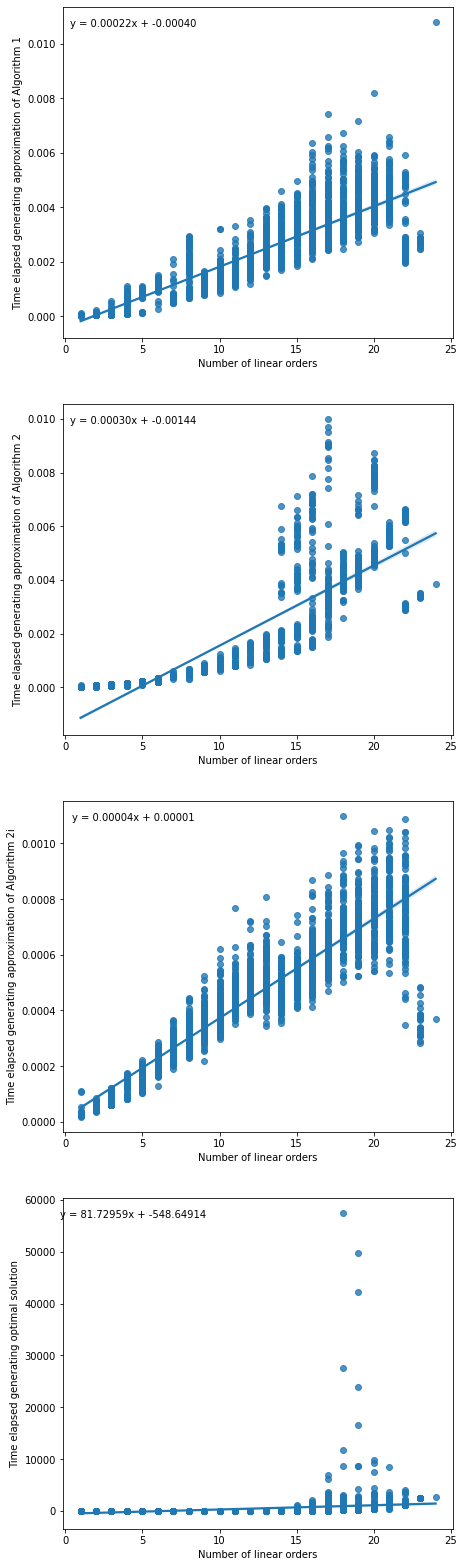

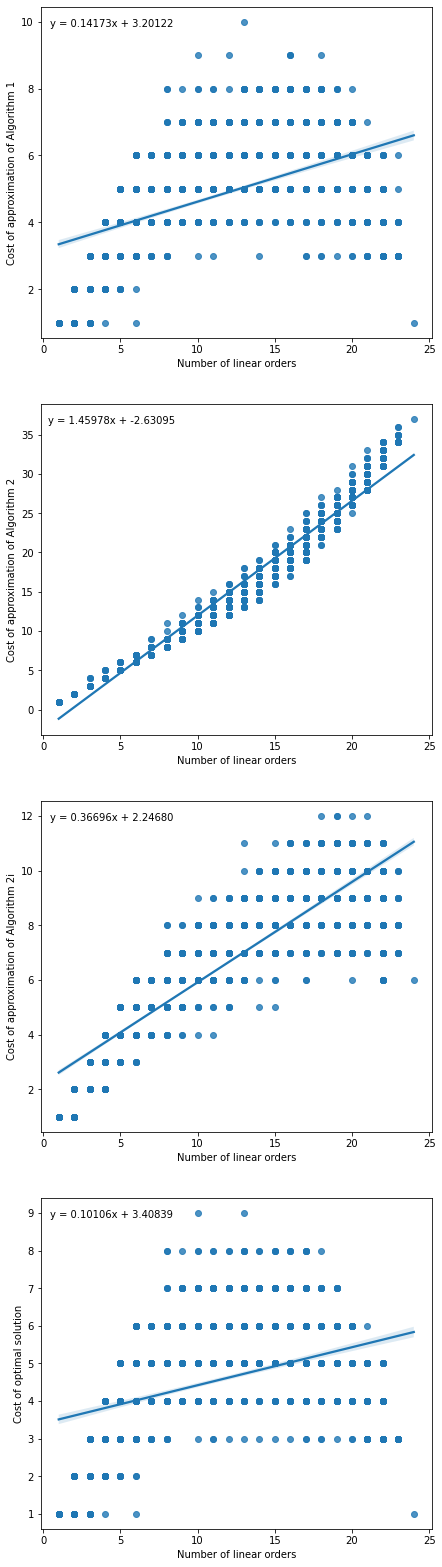

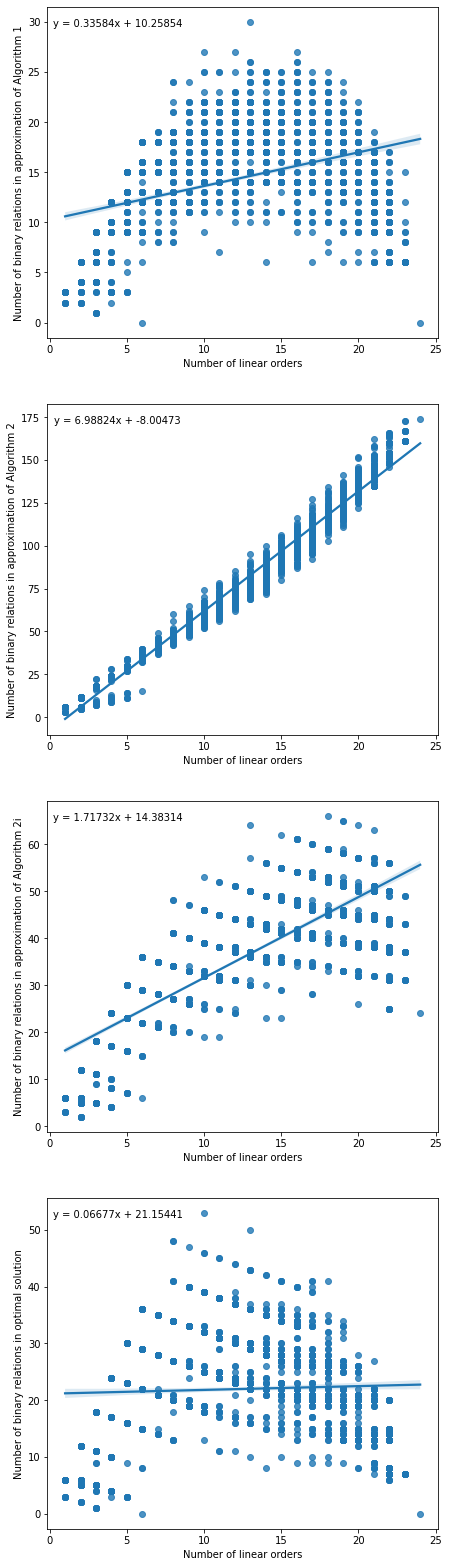

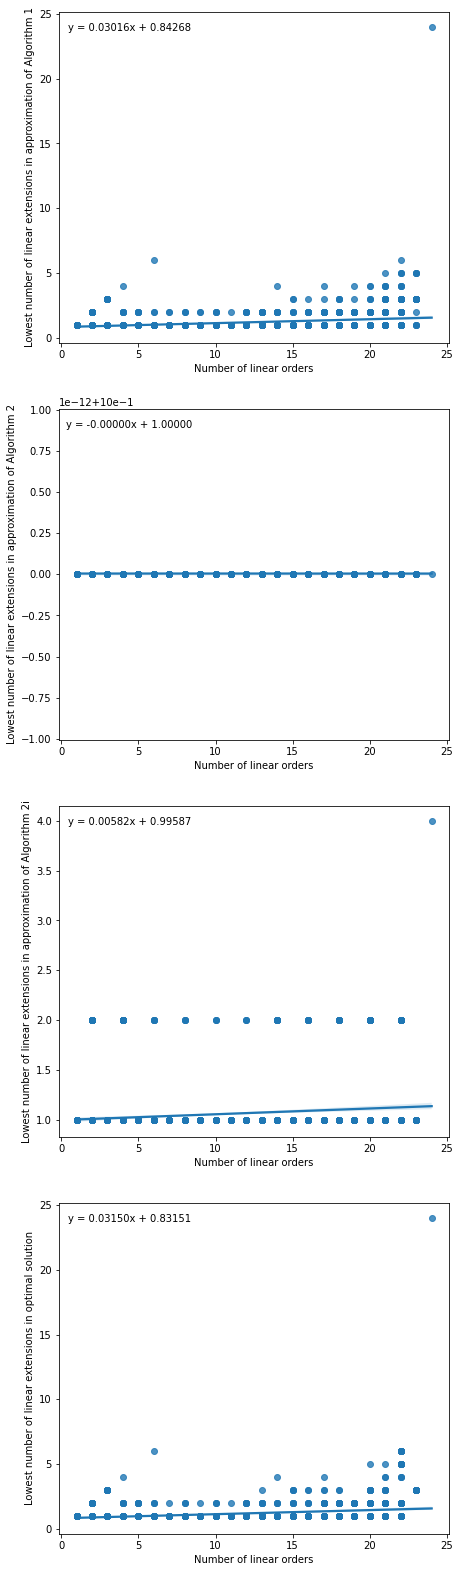

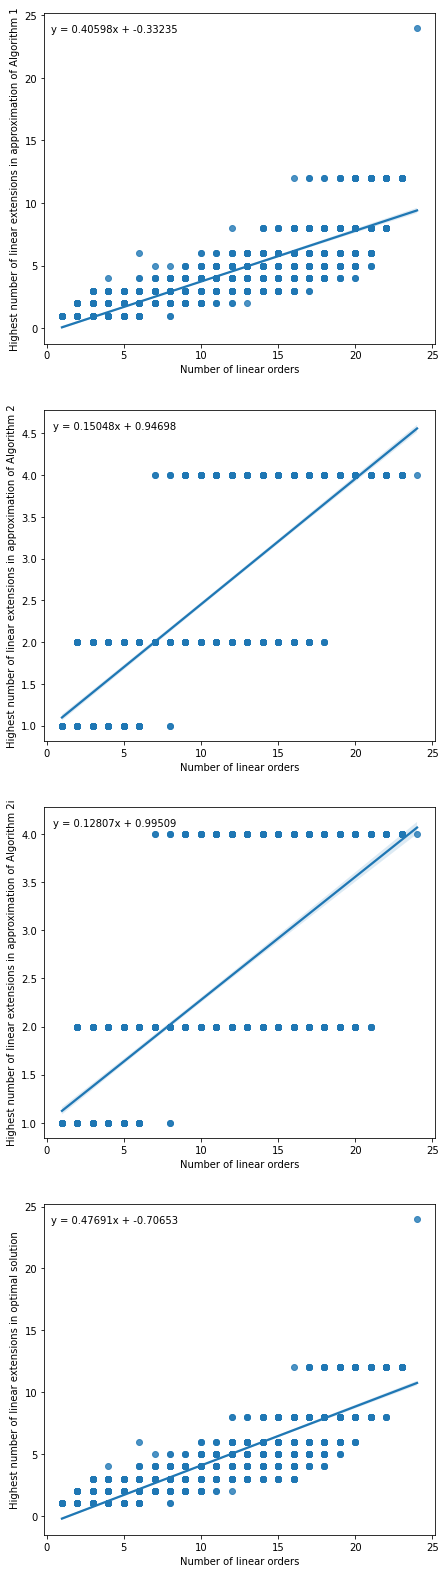

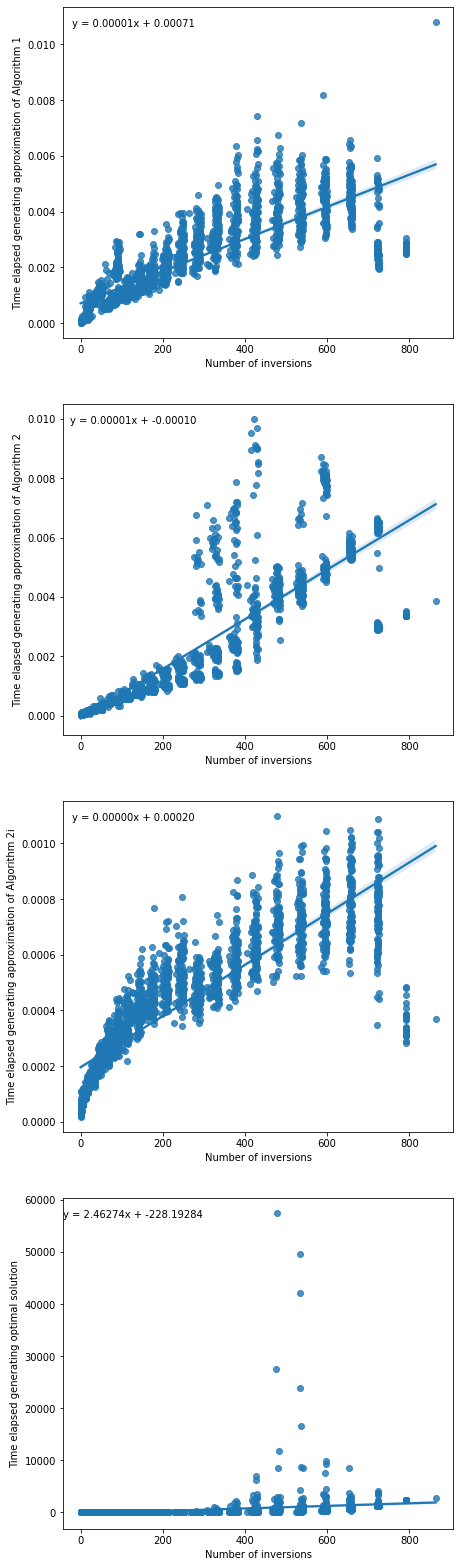

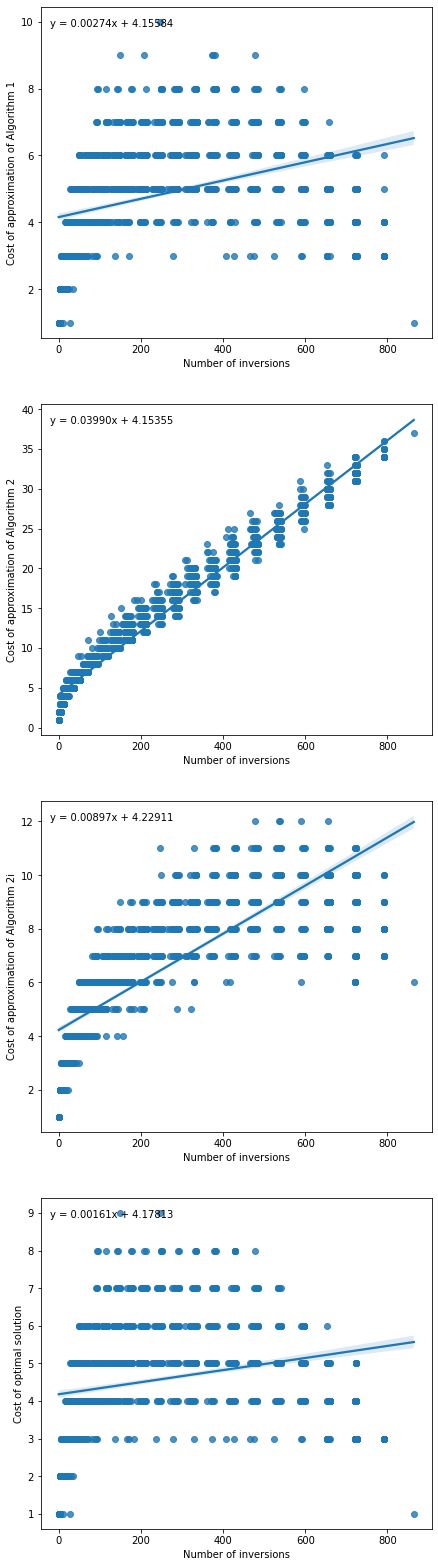

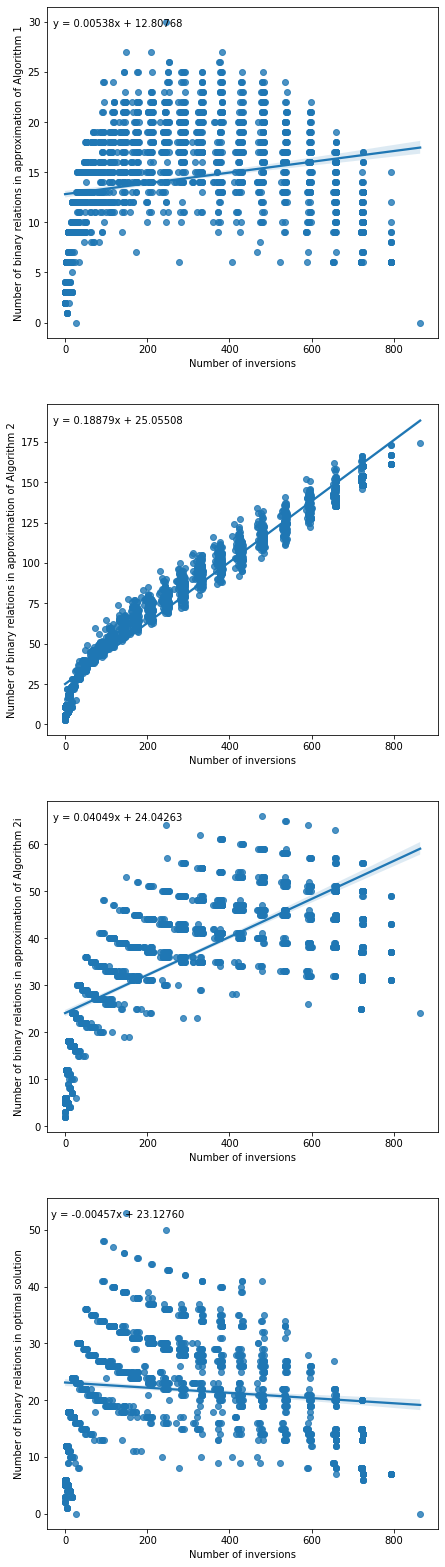

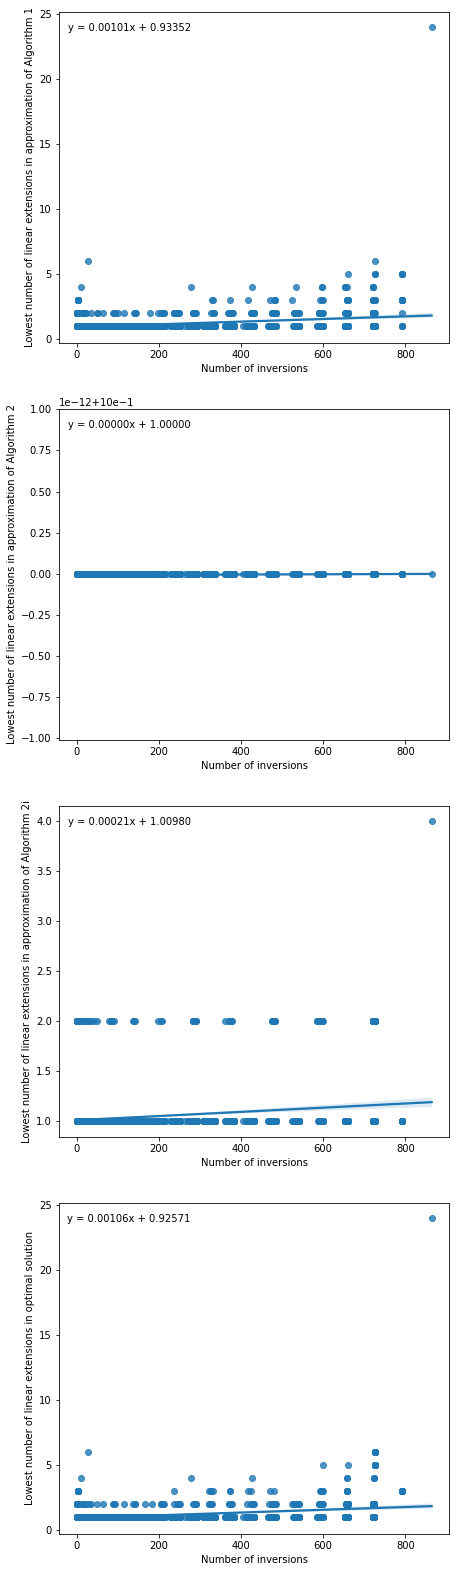

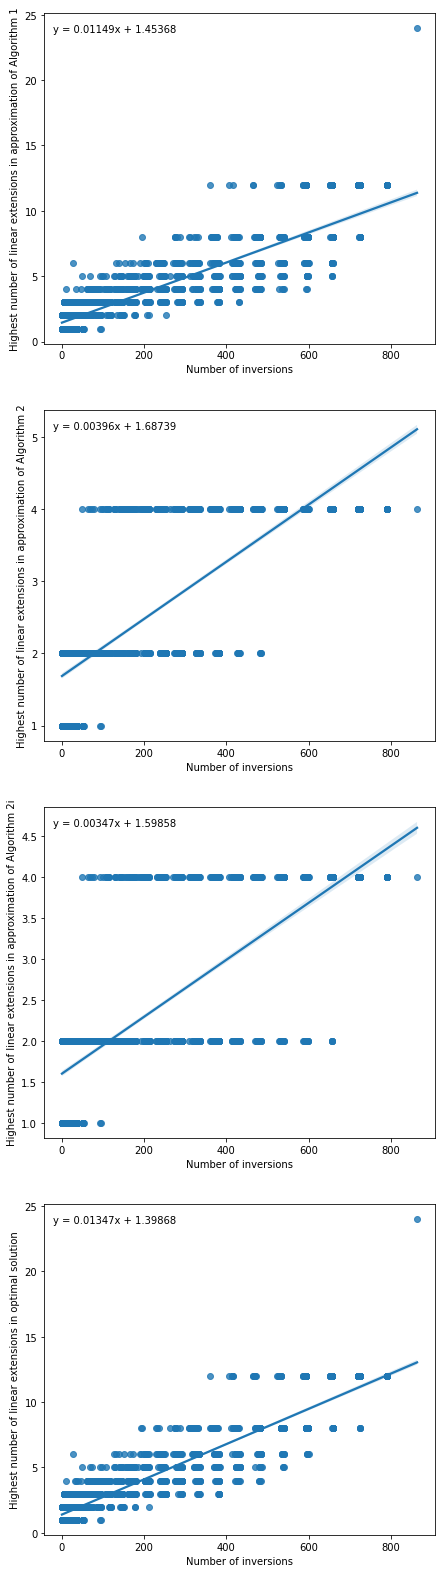

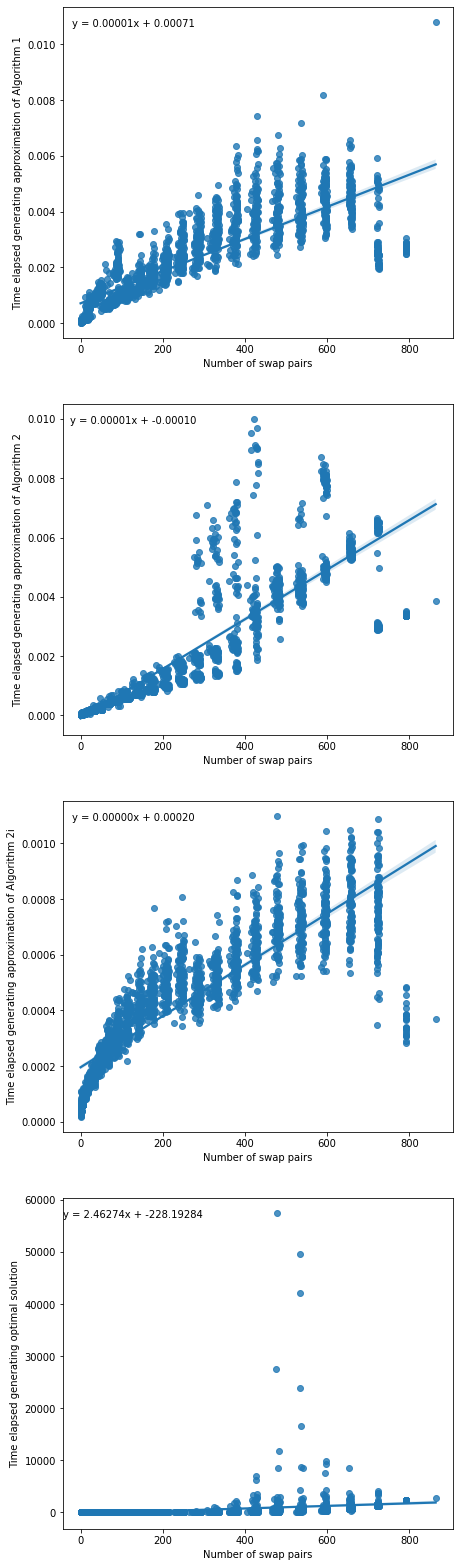

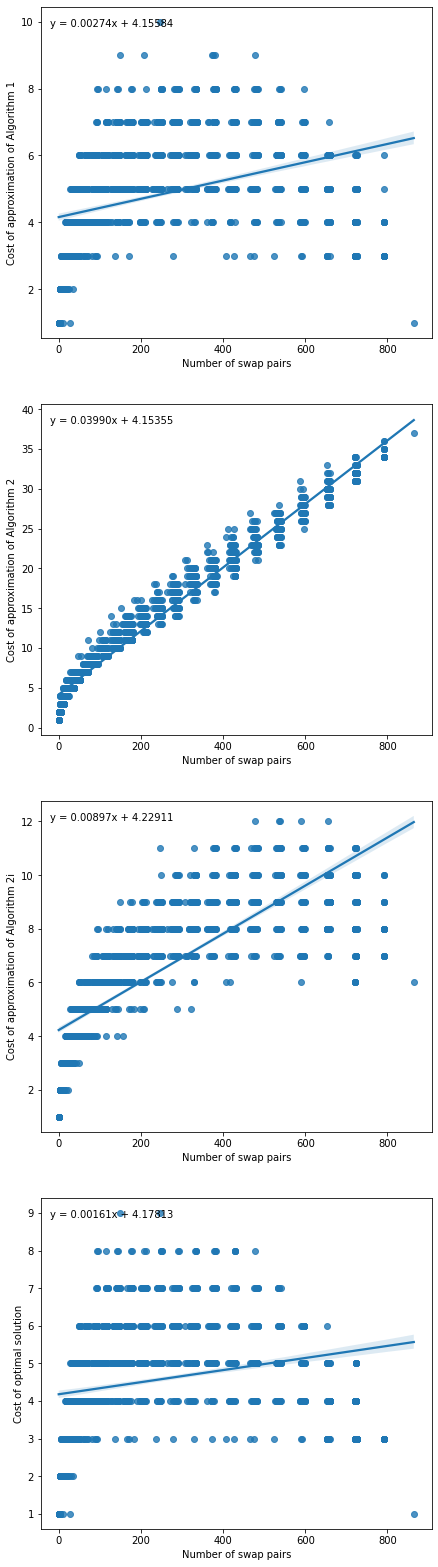

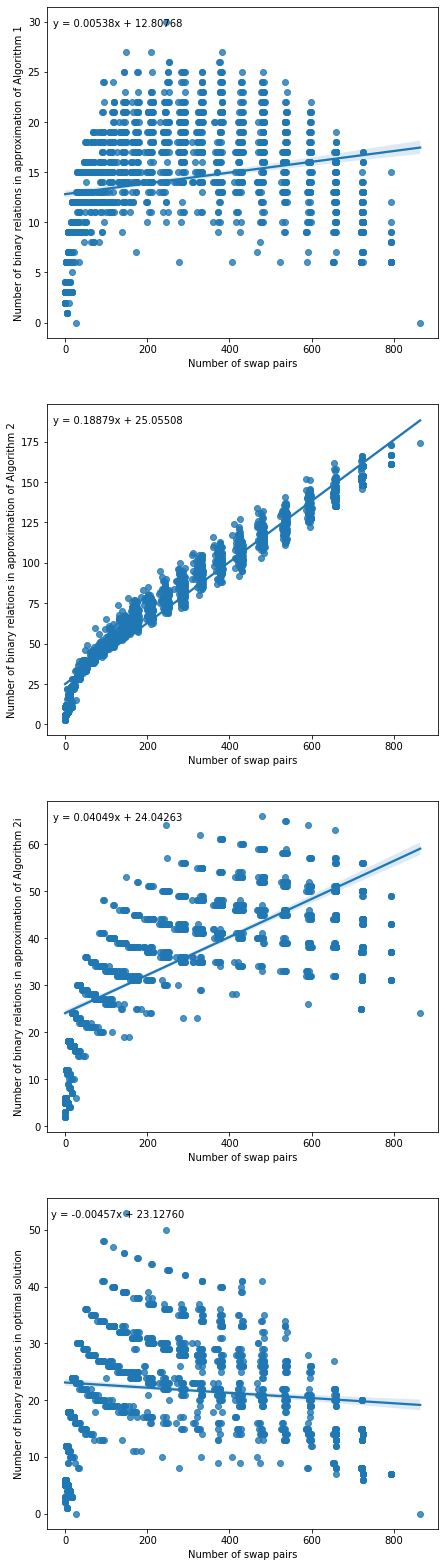

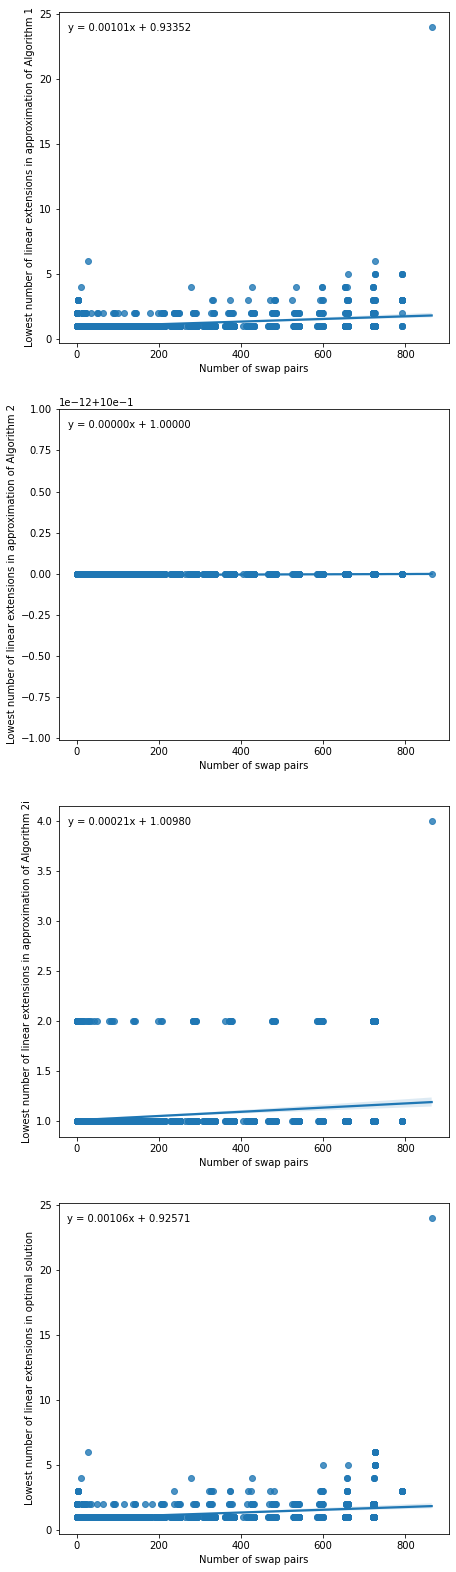

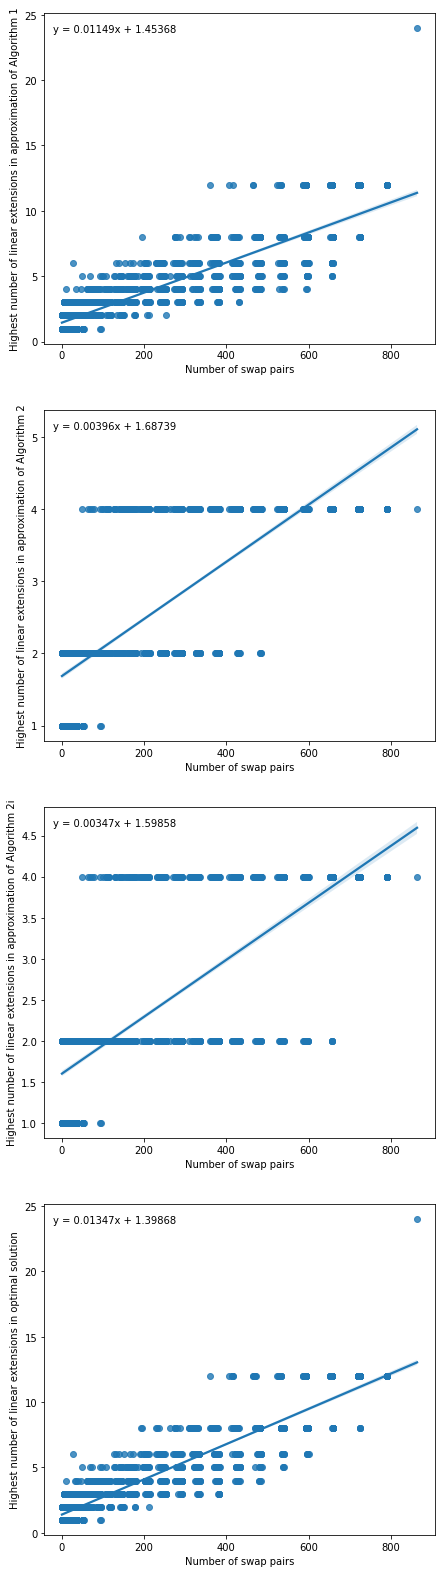

In [25]:
keywords = ['algo1', 'algo2', 'algo2i', 'optsol']
x_attributes = ['input_size', 'num_inversion', 'num_swap_pair']
y_attributes = ['runtime', 'cost', 'num_rel', 'min_lin_ext', 'max_lin_ext']
for x_attribute in x_attributes:
    for y_attribute in y_attributes:
        plotScatters(results_vc['all'], 
                     [x_attribute] + [f'{y_attribute}_{keyword}' for keyword in keywords],
                     'vertices')

In [14]:
optapprox = {}
keywords = ['algo1', 'algo2', 'algo2i']
for keyword in keywords:
    optapprox[keyword] = getApproxVsVal(results_vc[keyword], keyword, 'cost_diff', 0)
    
for keyword in keywords:
    optapprox_algo = optapprox[keyword]
    for vc in range(3, 5):
        print(optapprox_algo[optapprox_algo['vertex_count'] == vc].shape)
    print(optapprox_algo.shape)
    print('---')

(62, 14)
(1672, 14)
(1734, 14)
---
(17, 14)
(247, 14)
(264, 14)
---
(43, 14)
(671, 14)
(714, 14)
---


In [15]:
nonoptapprox = {}
keywords = ['algo1', 'algo2', 'algo2i']
for keyword in keywords:
    nonoptapprox[keyword] = getApproxVsVal(results_vc[keyword], keyword, 'cost_diff', 0, 'neq')
    
for keyword in keywords:
    nonoptapprox_algo = nonoptapprox[keyword]
    for vc in range(3, 5):
        print(nonoptapprox_algo[nonoptapprox_algo['vertex_count'] == vc].shape)
    print(nonoptapprox_algo.shape)
    print('---')

(1, 14)
(477, 14)
(478, 14)
---
(46, 14)
(1902, 14)
(1948, 14)
---
(20, 14)
(1478, 14)
(1498, 14)
---


In [16]:
sameapprox = {}
keywords = ['algo1', 'algo2', 'algo2i']
for i in range(len(keywords)):
    for j in range(i + 1, len(keywords)):
        sameapprox[f'{keywords[i]}_{keywords[j]}'] = getApproxVsApprox(results_vc['all'], keywords[i], keywords[j],
                                                                       'cost')
for key in sameapprox.keys():
    print(f'{sameapprox[key].shape} - {key}')

(264, 43) - algo1_algo2
(759, 43) - algo1_algo2i
(264, 43) - algo2_algo2i


In [17]:
allv3 = results_vc['all'][results_vc['all']['vertex_count'] == 3]
with pd.option_context('mode.chained_assignment', None):
    extendMore(allv3)
    
allv3[['input', 'is_opt_algo1', 'is_opt_algo2', 'is_opt_algo2i', 
       'cost_optsol', 'cost_algo1', 'cost_algo2', 'cost_algo2i']]

,input,is_opt_algo1,is_opt_algo2,is_opt_algo2i,cost_optsol,cost_algo1,cost_algo2,cost_algo2i
0,"[1, 2, 3]",True,True,True,1,1,1,1
1,"[1, 3, 2]",True,True,True,1,1,1,1
2,"[2, 1, 3]",True,True,True,1,1,1,1
3,"[2, 3, 1]",True,True,True,1,1,1,1
4,"[3, 1, 2]",True,True,True,1,1,1,1
5,"[3, 2, 1]",True,True,True,1,1,1,1
6,"[1, 2, 3]-[1, 3, 2]",True,False,True,1,1,2,1
7,"[1, 2, 3]-[2, 1, 3]",True,False,True,1,1,2,1
8,"[1, 2, 3]-[2, 3, 1]",True,True,True,2,2,2,2
9,"[1, 2, 3]-[3, 1, 2]",True,True,True,2,2,2,2


## Trees

In [8]:
results_trees = {}
joins_allvc = ['inner', 'inner', 'inner']
keywords = ['algo1', 'algo2', 'algo2i', 'optsol']
for vc in range(3, 7):
    results_trees[f'all{vc}'] = merge([csv[f'{keyword}_{vc}v_trees'] for keyword in keywords], joins_allvc)

joins_all_optsol = ['outer' for vc in range(3, 6)]
results_trees['all'] = merge([results_trees[f'all{vc}'] for vc in range(3, 7)], joins_all_optsol)
for vc in range(3, 7):
    del results_trees[f'all{vc}']

extend(results_trees['all'])

In [9]:
keywords = ['algo1', 'algo2', 'algo2i', 'optsol']
for keyword in keywords:
    input_attr = ['input', 'input_size', 'vertex_count', 'num_inversion', 'num_swap_pair']
    output_attr = ['cost', 'output', 'runtime', 'num_rel', 'lin_ext', 'max_lin_ext', 'min_lin_ext', 
                   'approx', 'cost_diff']
    
    if keyword == 'optsol':
        output_attr = output_attr[:-2]
    results_trees[keyword] = results_trees['all'][input_attr + [f'{attr}_{keyword}' for attr in output_attr]]

In [10]:
dimensions = []
keywords = ['all', 'algo1', 'algo2', 'algo2i', 'optsol']
for keyword in keywords:
    dimensions.append(results_trees[keyword].shape)
    for vc in range(3, 7):
        dimensions.append(results_trees[keyword][results_trees[keyword]['vertex_count'] == vc].shape)

for i in range(0, len(dimensions), 5):
    print(dimensions[i: i + 5])

[(43612, 43), (12, 43), (128, 43), (2000, 43), (41472, 43)]
[(43612, 14), (12, 14), (128, 14), (2000, 14), (41472, 14)]
[(43612, 14), (12, 14), (128, 14), (2000, 14), (41472, 14)]
[(43612, 14), (12, 14), (128, 14), (2000, 14), (41472, 14)]
[(43612, 12), (12, 12), (128, 12), (2000, 12), (41472, 12)]


In [11]:
results_trees['all'].head()

,input,cost_algo1,output_algo1,runtime_algo1,cost_algo2,output_algo2,runtime_algo2,cost_algo2i,output_algo2i,runtime_algo2i,cost_optsol,output_optsol,runtime_optsol,input_size,vertex_count,num_inversion,num_swap_pair,num_rel_algo1,lin_ext_algo1,num_lin_ext_algo1,min_lin_ext_algo1,max_lin_ext_algo1,approx_algo1,cost_diff_algo1,num_rel_algo2,lin_ext_algo2,num_lin_ext_algo2,min_lin_ext_algo2,max_lin_ext_algo2,approx_algo2,cost_diff_algo2,num_rel_algo2i,lin_ext_algo2i,num_lin_ext_algo2i,min_lin_ext_algo2i,max_lin_ext_algo2i,approx_algo2i,cost_diff_algo2i,num_rel_optsol,lin_ext_optsol,num_lin_ext_optsol,min_lin_ext_optsol,max_lin_ext_optsol
0,"[1, 2, 3]-[1, 3, 2]",1,"[[(1, 2), (1, 3)]]",0.000087,2,"[[(1, 2), (1, 3)], [(1, 2), (1, 3), (3, 2)]]",0.000076,1,"[[(1, 2), (1, 3)]]",0.000067,1,"[[(1, 2), (1, 3)]]",0.000009,2,3,1,1,2,"[[[1, 2, 3], [1, 3, 2]]]",[2],2,2,1.0,0,5,"[[[1, 2, 3], [1, 3, 2]], [[1, 3, 2]]]","[2, 1]",1,2,2.0,1,2,"[[[1, 2, 3], [1, 3, 2]]]",[2],2,2,1.0,0,2,"[[[1, 2, 3], [1, 3, 2]]]",[2],2,2
1,"[3, 1, 2]",1,"[[(1, 2), (3, 1)]]",0.000021,1,"[[(1, 2), (3, 1), (3, 2)]]",0.000018,1,"[[(1, 2), (3, 1), (3, 2)]]",0.000013,1,"[[(1, 2), (3, 1)]]",0.000009,1,3,0,0,2,"[[[3, 1, 2]]]",[1],1,1,1.0,0,3,"[[[3, 1, 2]]]",[1],1,1,1.0,0,3,"[[[3, 1, 2]]]",[1],1,1,1.0,0,2,"[[[3, 1, 2]]]",[1],1,1
2,"[2, 1, 3]",1,"[[(1, 3), (2, 1)]]",0.000028,1,"[[(1, 3), (2, 1), (2, 3)]]",0.000012,1,"[[(1, 3), (2, 1), (2, 3)]]",0.000009,1,"[[(1, 3), (2, 1)]]",0.000009,1,3,0,0,2,"[[[2, 1, 3]]]",[1],1,1,1.0,0,3,"[[[2, 1, 3]]]",[1],1,1,1.0,0,3,"[[[2, 1, 3]]]",[1],1,1,1.0,0,2,"[[[2, 1, 3]]]",[1],1,1
3,"[2, 3, 1]-[3, 2, 1]",1,"[[(2, 1), (3, 1)]]",0.000045,2,"[[(2, 1), (3, 1)], [(2, 1), (3, 1), (3, 2)]]",0.000030,1,"[[(2, 1), (3, 1)]]",0.000025,1,"[[(2, 1), (3, 1)]]",0.000009,2,3,1,1,2,"[[[2, 3, 1], [3, 2, 1]]]",[2],2,2,1.0,0,5,"[[[2, 3, 1], [3, 2, 1]], [[3, 2, 1]]]","[2, 1]",1,2,2.0,1,2,"[[[2, 3, 1], [3, 2, 1]]]",[2],2,2,1.0,0,2,"[[[2, 3, 1], [3, 2, 1]]]",[2],2,2
4,"[1, 2, 3]",1,"[[(1, 2), (2, 3)]]",0.000018,1,"[[(1, 2), (1, 3), (2, 3)]]",0.000012,1,"[[(1, 2), (1, 3), (2, 3)]]",0.000009,1,"[[(1, 2), (2, 3)]]",0.000009,1,3,0,0,2,"[[[1, 2, 3]]]",[1],1,1,1.0,0,3,"[[[1, 2, 3]]]",[1],1,1,1.0,0,3,"[[[1, 2, 3]]]",[1],1,1,1.0,0,2,"[[[1, 2, 3]]]",[1],1,1


In [22]:
results_trees['all'].describe()

,cost_algo1,runtime_algo1,cost_algo2,runtime_algo2,cost_algo2i,runtime_algo2i,cost_optsol,runtime_optsol,input_size,vertex_count,num_inversion,num_swap_pair,num_rel_algo1,min_lin_ext_algo1,max_lin_ext_algo1,approx_algo1,cost_diff_algo1,num_rel_algo2,min_lin_ext_algo2,max_lin_ext_algo2,approx_algo2,cost_diff_algo2,num_rel_algo2i,min_lin_ext_algo2i,max_lin_ext_algo2i,approx_algo2i,cost_diff_algo2i,num_rel_optsol,min_lin_ext_optsol,max_lin_ext_optsol
count,43612.0,43612.000000,43612.000000,43612.000000,43612.000000,43612.000000,43612.0,43612.000000,43612.000000,43612.000000,43612.000000,43612.000000,43612.000000,43612.000000,43612.000000,43612.0,43612.0,43612.000000,43612.0,43612.000000,43612.000000,43612.000000,43612.000000,43612.000000,43612.000000,43612.000000,43612.000000,43612.000000,43612.000000,43612.000000
mean,1.0,0.084979,47.904659,0.047799,7.972783,0.001469,1.0,0.006125,21.749106,5.947446,1386.735348,1386.735348,4.947446,21.749106,21.749106,1.0,0.0,627.020958,1.0,5.288132,47.904659,46.904659,108.568765,1.416560,3.972347,7.972783,6.972783,4.947446,21.749106,21.749106
std,0.0,0.200479,49.929041,0.093530,5.188295,0.001640,0.0,0.001330,17.329736,0.239405,2497.800127,2497.800127,0.239405,17.329736,17.329736,0.0,0.0,645.389583,0.0,2.358997,49.929041,49.929041,70.719874,0.547473,1.716970,5.188295,5.188295,0.239405,17.329736,17.329736
min,1.0,0.000017,1.000000,0.000010,1.000000,0.000008,1.0,0.000009,1.000000,3.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.0,0.0,3.000000,1.0,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000
25%,1.0,0.002521,13.000000,0.002225,4.000000,0.000349,1.0,0.006427,9.000000,6.000000,80.000000,80.000000,5.000000,9.000000,9.000000,1.0,0.0,177.000000,1.0,4.000000,13.000000,12.000000,54.000000,1.000000,4.000000,4.000000,3.000000,5.000000,9.000000,9.000000
50%,1.0,0.010656,29.000000,0.010556,7.000000,0.000838,1.0,0.006427,16.000000,6.000000,322.000000,322.000000,5.000000,16.000000,16.000000,1.0,0.0,395.000000,1.0,4.000000,29.000000,28.000000,95.000000,1.000000,4.000000,7.000000,6.000000,5.000000,16.000000,16.000000
75%,1.0,0.073235,72.000000,0.056390,11.000000,0.002058,1.0,0.006427,32.000000,6.000000,1684.000000,1684.000000,5.000000,32.000000,32.000000,1.0,0.0,946.000000,1.0,8.000000,72.000000,71.000000,153.000000,2.000000,4.000000,11.000000,10.000000,5.000000,32.000000,32.000000
max,1.0,5.685967,261.000000,0.850385,30.000000,0.012446,1.0,0.006427,120.000000,6.000000,36000.000000,36000.000000,5.000000,120.000000,120.000000,1.0,0.0,3475.000000,1.0,8.000000,261.000000,260.000000,390.000000,4.000000,8.000000,30.000000,29.000000,5.000000,120.000000,120.000000


In [23]:
results_trees['all'][results_trees['all']['vertex_count'] == 3].describe()

,cost_algo1,runtime_algo1,cost_algo2,runtime_algo2,cost_algo2i,runtime_algo2i,cost_optsol,runtime_optsol,input_size,vertex_count,num_inversion,num_swap_pair,num_rel_algo1,min_lin_ext_algo1,max_lin_ext_algo1,approx_algo1,cost_diff_algo1,num_rel_algo2,min_lin_ext_algo2,max_lin_ext_algo2,approx_algo2,cost_diff_algo2,num_rel_algo2i,min_lin_ext_algo2i,max_lin_ext_algo2i,approx_algo2i,cost_diff_algo2i,num_rel_optsol,min_lin_ext_optsol,max_lin_ext_optsol
count,12.0,12.000000,12.000000,12.000000,12.0,12.000000,12.0,12.000000,12.000000,12.0,12.000000,12.000000,12.0,12.000000,12.000000,12.0,12.0,12.000000,12.0,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.0,12.0,12.0,12.000000,12.000000
mean,1.0,0.000035,1.500000,0.000025,1.0,0.000019,1.0,0.000009,1.500000,3.0,0.500000,0.500000,2.0,1.500000,1.500000,1.0,0.0,4.000000,1.0,1.500000,1.500000,0.500000,2.500000,1.500000,1.500000,1.0,0.0,2.0,1.500000,1.500000
std,0.0,0.000020,0.522233,0.000018,0.0,0.000016,0.0,0.000000,0.522233,0.0,0.522233,0.522233,0.0,0.522233,0.522233,0.0,0.0,1.044466,0.0,0.522233,0.522233,0.522233,0.522233,0.522233,0.522233,0.0,0.0,0.0,0.522233,0.522233
min,1.0,0.000017,1.000000,0.000010,1.0,0.000008,1.0,0.000009,1.000000,3.0,0.000000,0.000000,2.0,1.000000,1.000000,1.0,0.0,3.000000,1.0,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.0,0.0,2.0,1.000000,1.000000
25%,1.0,0.000018,1.000000,0.000012,1.0,0.000009,1.0,0.000009,1.000000,3.0,0.000000,0.000000,2.0,1.000000,1.000000,1.0,0.0,3.000000,1.0,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.0,0.0,2.0,1.000000,1.000000
50%,1.0,0.000034,1.500000,0.000023,1.0,0.000016,1.0,0.000009,1.500000,3.0,0.500000,0.500000,2.0,1.500000,1.500000,1.0,0.0,4.000000,1.0,1.500000,1.500000,0.500000,2.500000,1.500000,1.500000,1.0,0.0,2.0,1.500000,1.500000
75%,1.0,0.000042,2.000000,0.000029,1.0,0.000020,1.0,0.000009,2.000000,3.0,1.000000,1.000000,2.0,2.000000,2.000000,1.0,0.0,5.000000,1.0,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,1.0,0.0,2.0,2.000000,2.000000
max,1.0,0.000087,2.000000,0.000076,1.0,0.000067,1.0,0.000009,2.000000,3.0,1.000000,1.000000,2.0,2.000000,2.000000,1.0,0.0,5.000000,1.0,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,1.0,0.0,2.0,2.000000,2.000000


In [24]:
results_trees['all'][results_trees['all']['vertex_count'] == 4].describe()

,cost_algo1,runtime_algo1,cost_algo2,runtime_algo2,cost_algo2i,runtime_algo2i,cost_optsol,runtime_optsol,input_size,vertex_count,num_inversion,num_swap_pair,num_rel_algo1,min_lin_ext_algo1,max_lin_ext_algo1,approx_algo1,cost_diff_algo1,num_rel_algo2,min_lin_ext_algo2,max_lin_ext_algo2,approx_algo2,cost_diff_algo2,num_rel_algo2i,min_lin_ext_algo2i,max_lin_ext_algo2i,approx_algo2i,cost_diff_algo2i,num_rel_optsol,min_lin_ext_optsol,max_lin_ext_optsol
count,128.0,128.000000,128.000000,128.000000,128.000000,128.000000,128.0,1.280000e+02,128.000000,128.0,128.000000,128.000000,128.0,128.000000,128.000000,128.0,128.0,128.000000,128.0,128.00000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.0,128.000000,128.000000
mean,1.0,0.000200,3.367188,0.000073,1.781250,0.000036,1.0,2.735000e-05,3.000000,4.0,6.375000,6.375000,3.0,3.000000,3.000000,1.0,0.0,17.578125,1.0,2.18750,3.367188,2.367188,9.562500,1.250000,2.000000,1.781250,0.781250,3.0,3.000000,3.000000
std,0.0,0.000165,1.991601,0.000060,0.698001,0.000021,0.0,1.020433e-20,1.505894,0.0,7.718472,7.718472,0.0,1.505894,1.505894,0.0,0.0,9.544433,0.0,0.95365,1.991601,1.991601,3.592972,0.434714,0.752947,0.698001,0.698001,0.0,1.505894,1.505894
min,1.0,0.000022,1.000000,0.000011,1.000000,0.000009,1.0,2.735000e-05,1.000000,4.0,0.000000,0.000000,3.0,1.000000,1.000000,1.0,0.0,6.000000,1.0,1.00000,1.000000,0.000000,5.000000,1.000000,1.000000,1.000000,0.000000,3.0,1.000000,1.000000
25%,1.0,0.000092,2.000000,0.000033,1.000000,0.000023,1.0,2.735000e-05,2.000000,4.0,1.000000,1.000000,3.0,2.000000,2.000000,1.0,0.0,11.000000,1.0,2.00000,2.000000,1.000000,6.000000,1.000000,2.000000,1.000000,0.000000,3.0,2.000000,2.000000
50%,1.0,0.000179,3.000000,0.000055,2.000000,0.000032,1.0,2.735000e-05,3.000000,4.0,4.000000,4.000000,3.0,3.000000,3.000000,1.0,0.0,16.000000,1.0,2.00000,3.000000,2.000000,11.000000,1.000000,2.000000,2.000000,1.000000,3.0,3.000000,3.000000
75%,1.0,0.000216,4.500000,0.000088,2.000000,0.000055,1.0,2.735000e-05,3.500000,4.0,7.000000,7.000000,3.0,3.500000,3.500000,1.0,0.0,23.750000,1.0,2.00000,4.500000,3.500000,11.000000,1.250000,2.000000,2.000000,1.000000,3.0,3.500000,3.500000
max,1.0,0.000688,7.000000,0.000222,3.000000,0.000123,1.0,2.735000e-05,6.000000,4.0,27.000000,27.000000,3.0,6.000000,6.000000,1.0,0.0,36.000000,1.0,4.00000,7.000000,6.000000,16.000000,2.000000,4.000000,3.000000,2.000000,3.0,6.000000,6.000000


In [25]:
results_trees['all'][results_trees['all']['vertex_count'] == 5].describe()

,cost_algo1,runtime_algo1,cost_algo2,runtime_algo2,cost_algo2i,runtime_algo2i,cost_optsol,runtime_optsol,input_size,vertex_count,num_inversion,num_swap_pair,num_rel_algo1,min_lin_ext_algo1,max_lin_ext_algo1,approx_algo1,cost_diff_algo1,num_rel_algo2,min_lin_ext_algo2,max_lin_ext_algo2,approx_algo2,cost_diff_algo2,num_rel_algo2i,min_lin_ext_algo2i,max_lin_ext_algo2i,approx_algo2i,cost_diff_algo2i,num_rel_optsol,min_lin_ext_optsol,max_lin_ext_optsol
count,2000.0,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.0,2.000000e+03,2000.000000,2000.0,2000.000000,2000.000000,2000.0,2000.000000,2000.000000,2000.0,2000.0,2000.000000,2000.0,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.0,2000.000000,2000.000000
mean,1.0,0.002484,10.625500,0.001353,3.409000,0.000309,1.0,2.875100e-04,7.500000,5.0,87.300000,87.300000,4.0,7.500000,7.500000,1.0,0.0,92.965000,1.0,3.180000,10.625500,9.625500,30.680000,1.472500,2.830000,3.409000,2.409000,4.0,7.500000,7.500000
std,0.0,0.003871,8.360634,0.001843,1.687941,0.000256,0.0,5.422367e-20,4.816804,0.0,127.342994,127.342994,0.0,4.816804,4.816804,0.0,0.0,70.711327,0.0,1.071529,8.360634,8.360634,14.741481,0.607806,1.073162,1.687941,1.687941,0.0,4.816804,4.816804
min,1.0,0.000023,1.000000,0.000014,1.000000,0.000011,1.0,2.875100e-04,1.000000,5.0,0.000000,0.000000,4.0,1.000000,1.000000,1.0,0.0,10.000000,1.0,1.000000,1.000000,0.000000,8.000000,1.000000,1.000000,1.000000,0.000000,4.0,1.000000,1.000000
25%,1.0,0.000294,4.000000,0.000150,2.000000,0.000106,1.0,2.875100e-04,4.000000,5.0,8.000000,8.000000,4.0,4.000000,4.000000,1.0,0.0,37.000000,1.0,2.000000,4.000000,3.000000,19.000000,1.000000,2.000000,2.000000,1.000000,4.0,4.000000,4.000000
50%,1.0,0.001074,9.000000,0.000754,3.000000,0.000245,1.0,2.875100e-04,7.000000,5.0,40.000000,40.000000,4.0,7.000000,7.000000,1.0,0.0,78.000000,1.0,4.000000,9.000000,8.000000,28.000000,1.000000,2.000000,3.000000,2.000000,4.0,7.000000,7.000000
75%,1.0,0.002625,15.000000,0.001509,5.000000,0.000410,1.0,2.875100e-04,9.000000,5.0,78.000000,78.000000,4.0,9.000000,9.000000,1.0,0.0,130.000000,1.0,4.000000,15.000000,14.000000,42.000000,2.000000,4.000000,5.000000,4.000000,4.0,9.000000,9.000000
max,1.0,0.029358,37.000000,0.011352,9.000000,0.001587,1.0,2.875100e-04,24.000000,5.0,864.000000,864.000000,4.0,24.000000,24.000000,1.0,0.0,322.000000,1.0,4.000000,37.000000,36.000000,82.000000,4.000000,4.000000,9.000000,8.000000,4.0,24.000000,24.000000


In [26]:
results_trees['all'][results_trees['all']['vertex_count'] == 6].describe()

,cost_algo1,runtime_algo1,cost_algo2,runtime_algo2,cost_algo2i,runtime_algo2i,cost_optsol,runtime_optsol,input_size,vertex_count,num_inversion,num_swap_pair,num_rel_algo1,min_lin_ext_algo1,max_lin_ext_algo1,approx_algo1,cost_diff_algo1,num_rel_algo2,min_lin_ext_algo2,max_lin_ext_algo2,approx_algo2,cost_diff_algo2,num_rel_algo2i,min_lin_ext_algo2i,max_lin_ext_algo2i,approx_algo2i,cost_diff_algo2i,num_rel_optsol,min_lin_ext_optsol,max_lin_ext_optsol
count,41472.0,41472.000000,41472.000000,41472.000000,41472.00000,41472.000000,41472.0,4.147200e+04,41472.000000,41472.0,41472.000000,41472.000000,41472.0,41472.000000,41472.000000,41472.0,41472.0,41472.000000,41472.0,41472.000000,41472.000000,41472.000000,41472.000000,41472.000000,41472.000000,41472.00000,41472.00000,41472.0,41472.000000,41472.000000
mean,1.0,0.089244,49.853347,0.050200,8.21400,0.001530,1.0,6.426780e-03,22.500000,6.0,1454.062500,1454.062500,5.0,22.500000,22.500000,1.0,0.0,654.837240,1.0,5.400463,49.853347,48.853347,112.661241,1.414352,4.034240,8.21400,7.21400,5.0,22.500000,22.500000
std,0.0,0.204682,50.404390,0.095298,5.19361,0.001658,0.0,1.734744e-18,17.410695,0.0,2543.180838,2543.180838,0.0,17.410695,17.410695,0.0,0.0,649.609728,0.0,2.352244,50.404390,50.404390,70.043075,0.544510,1.721118,5.19361,5.19361,0.0,17.410695,17.410695
min,1.0,0.000024,1.000000,0.000018,1.00000,0.000015,1.0,6.426780e-03,1.000000,6.0,0.000000,0.000000,5.0,1.000000,1.000000,1.0,0.0,15.000000,1.0,1.000000,1.000000,0.000000,13.000000,1.000000,1.000000,1.00000,0.00000,5.0,1.000000,1.000000
25%,1.0,0.002902,14.000000,0.002542,4.00000,0.000397,1.0,6.426780e-03,10.000000,6.0,99.000000,99.000000,5.0,10.000000,10.000000,1.0,0.0,189.000000,1.0,4.000000,14.000000,13.000000,56.000000,1.000000,4.000000,4.00000,3.00000,5.0,10.000000,10.000000
50%,1.0,0.012522,32.000000,0.011694,7.00000,0.000887,1.0,6.426780e-03,18.000000,6.0,409.000000,409.000000,5.0,18.000000,18.000000,1.0,0.0,431.000000,1.0,4.000000,32.000000,31.000000,98.000000,1.000000,4.000000,7.00000,6.00000,5.0,18.000000,18.000000
75%,1.0,0.079541,74.000000,0.057794,12.00000,0.002123,1.0,6.426780e-03,33.000000,6.0,1790.000000,1790.000000,5.0,33.000000,33.000000,1.0,0.0,970.000000,1.0,8.000000,74.000000,73.000000,161.000000,2.000000,4.000000,12.00000,11.00000,5.0,33.000000,33.000000
max,1.0,5.685967,261.000000,0.850385,30.00000,0.012446,1.0,6.426780e-03,120.000000,6.0,36000.000000,36000.000000,5.0,120.000000,120.000000,1.0,0.0,3475.000000,1.0,8.000000,261.000000,260.000000,390.000000,4.000000,8.000000,30.00000,29.00000,5.0,120.000000,120.000000


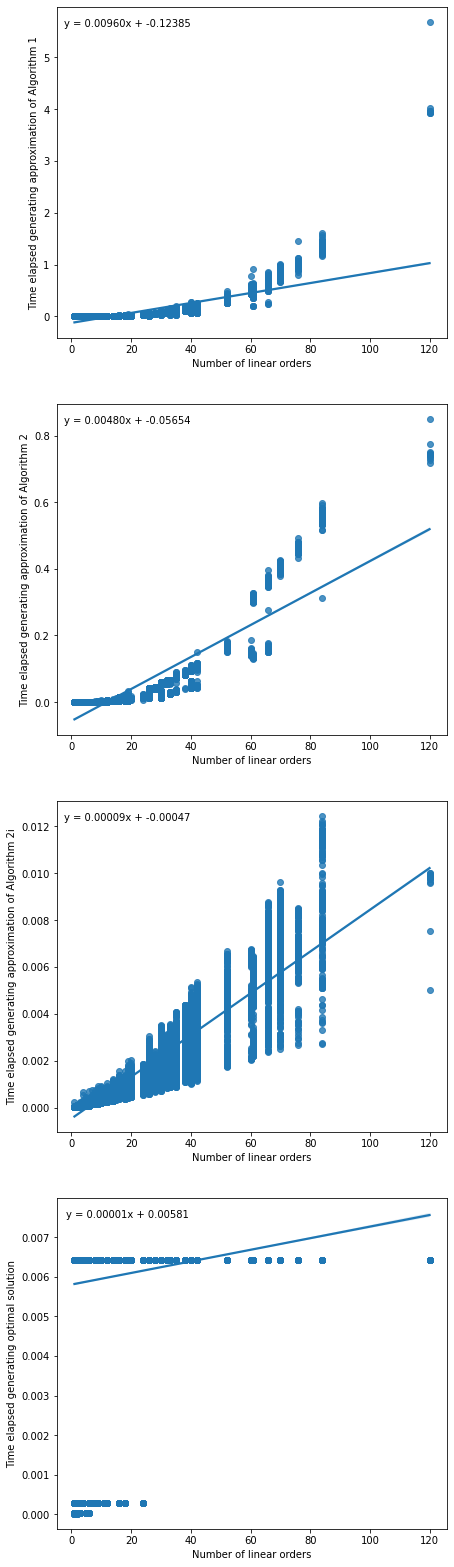

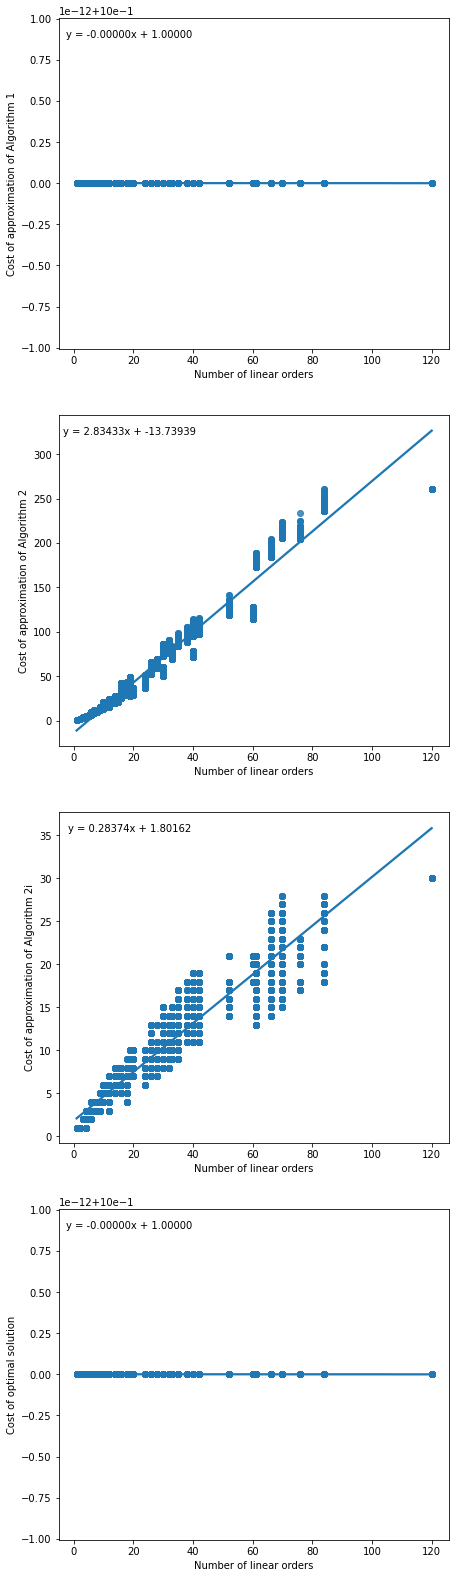

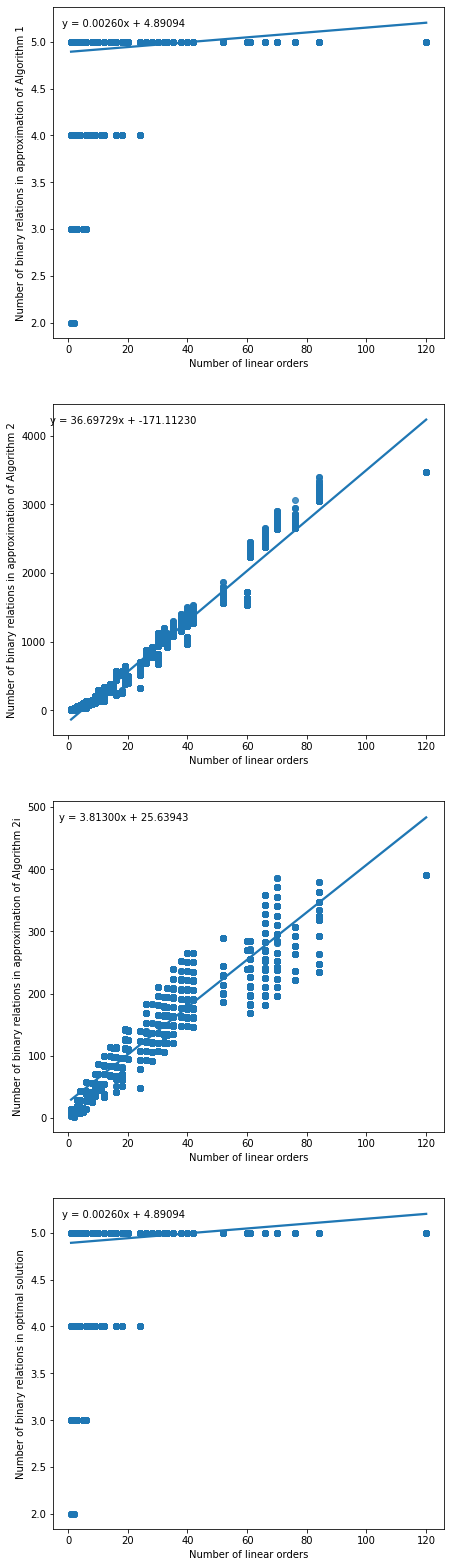

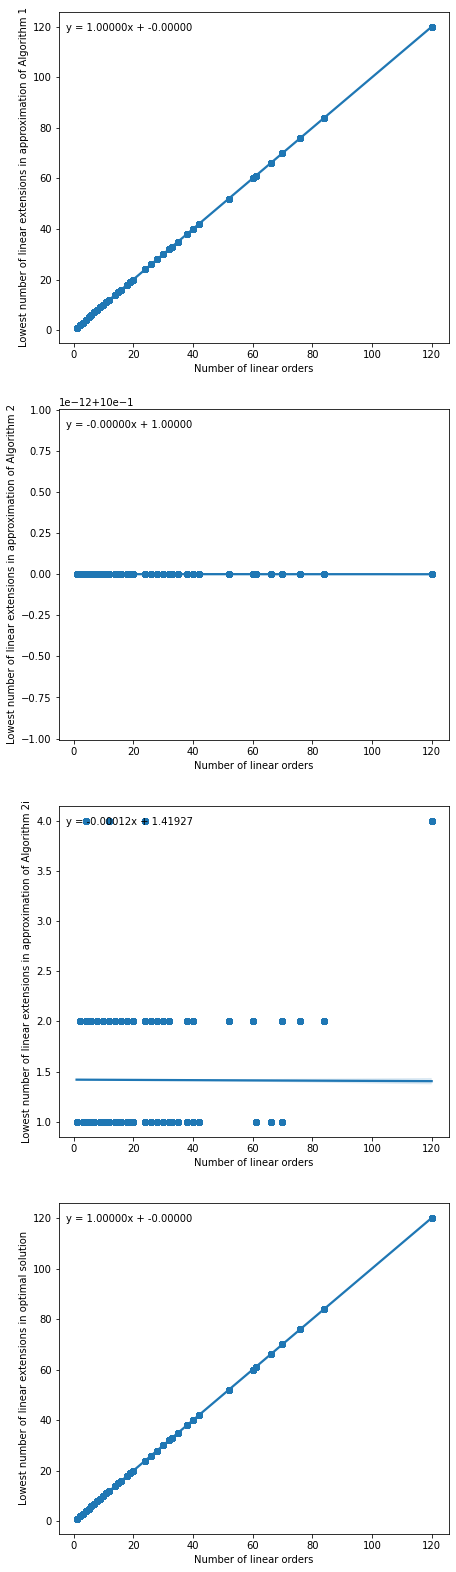

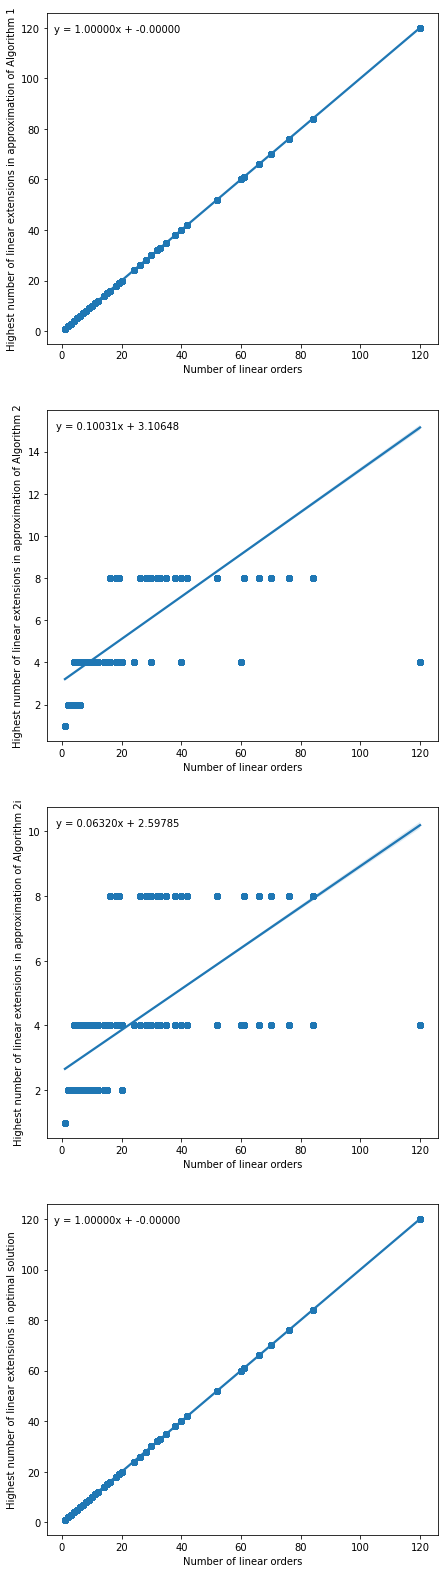

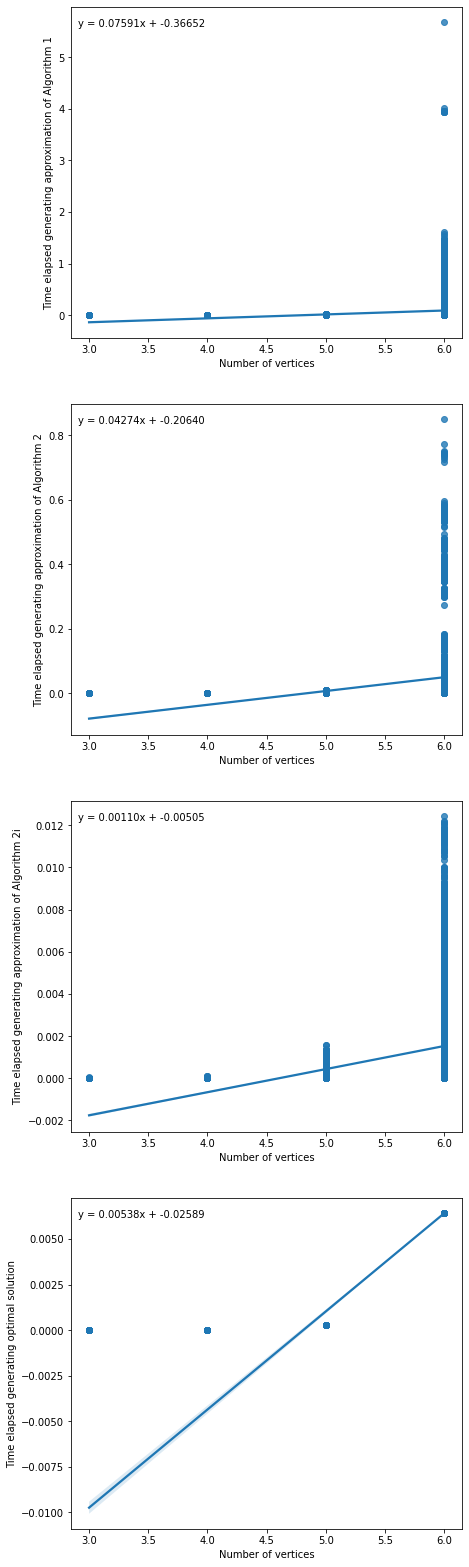

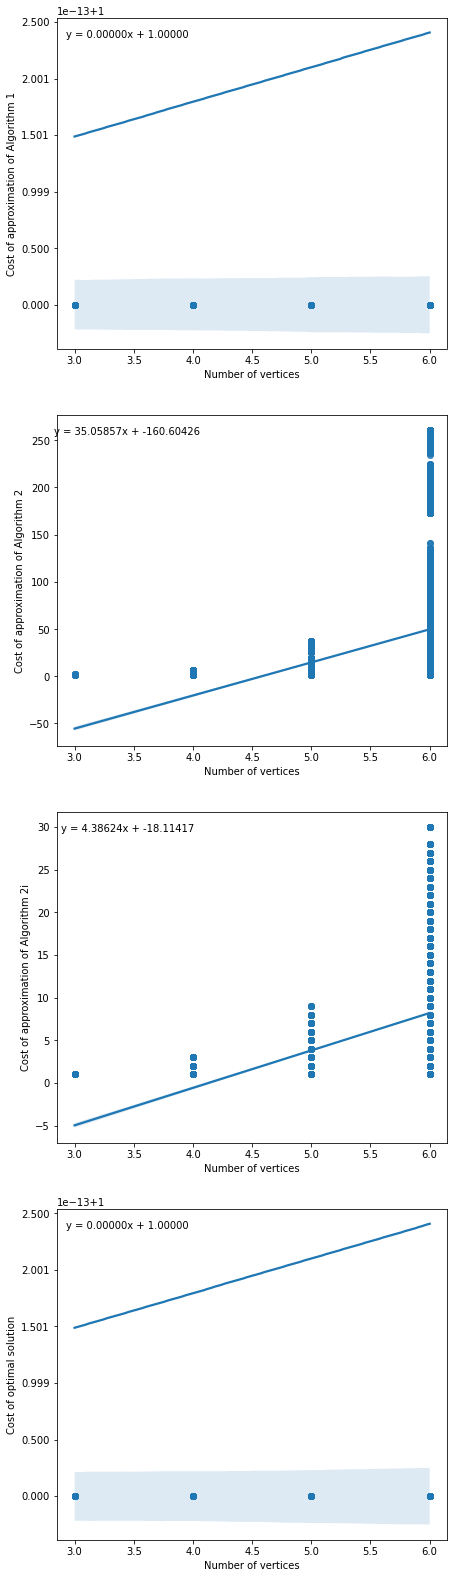

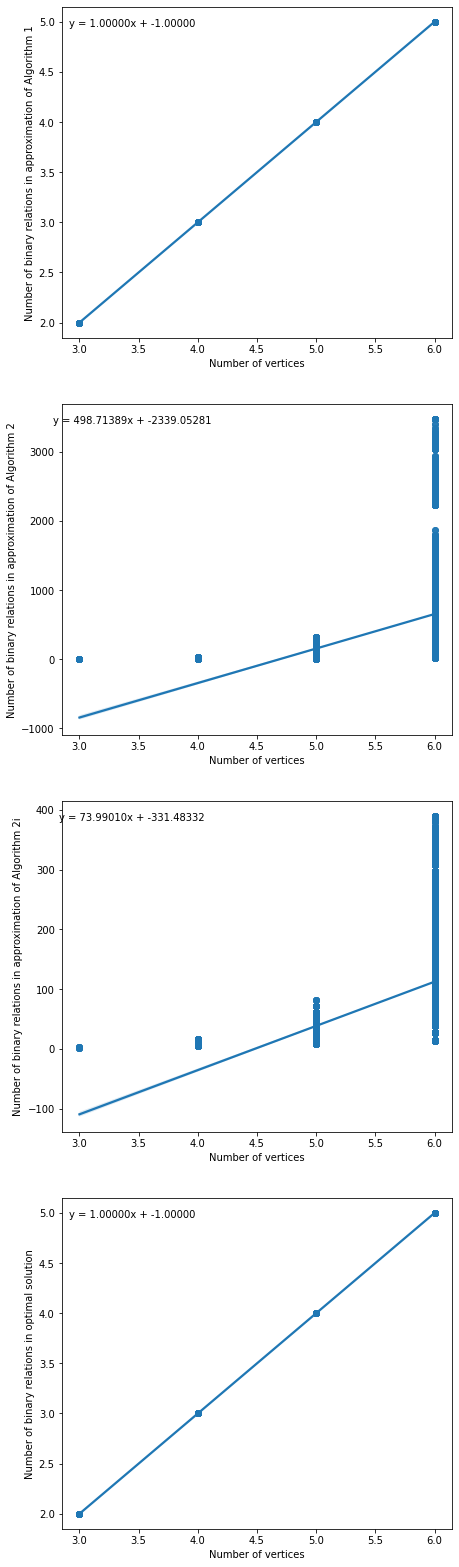

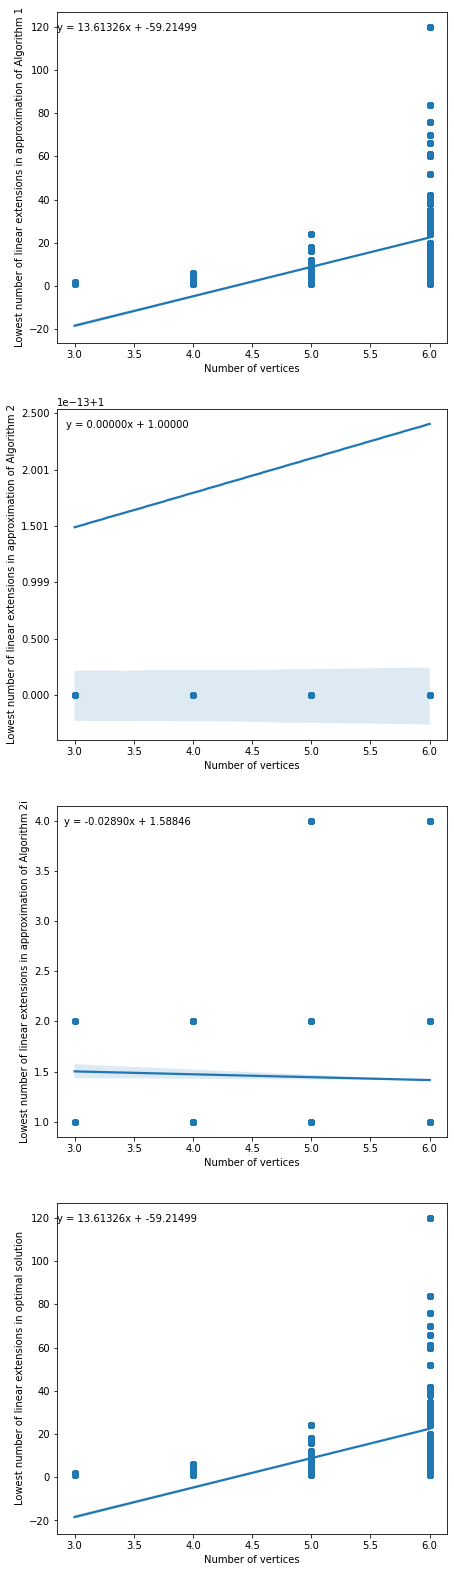

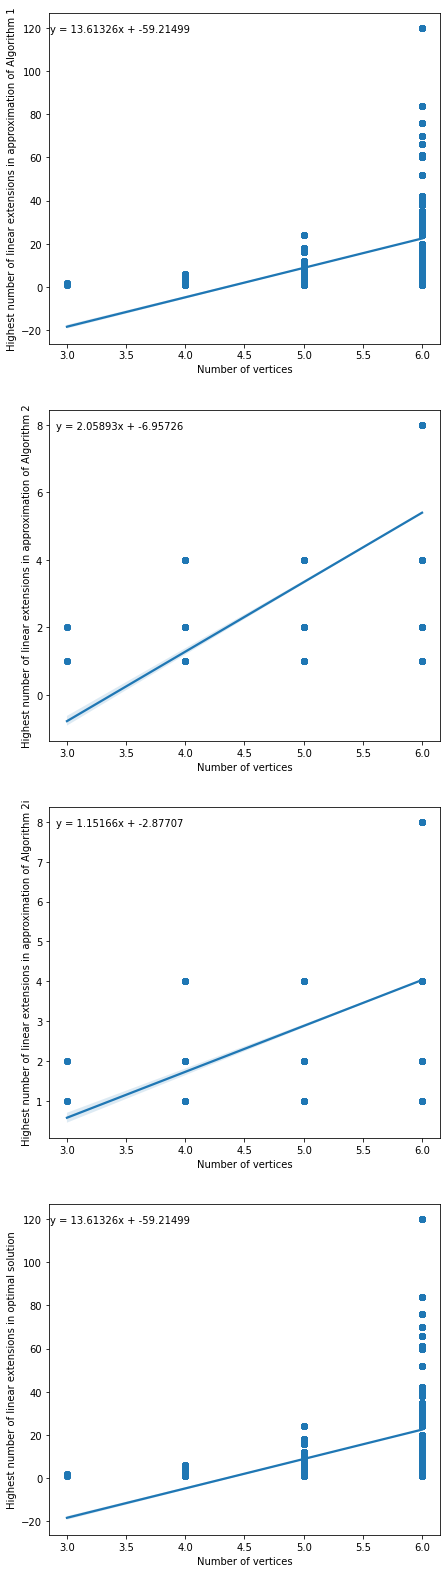

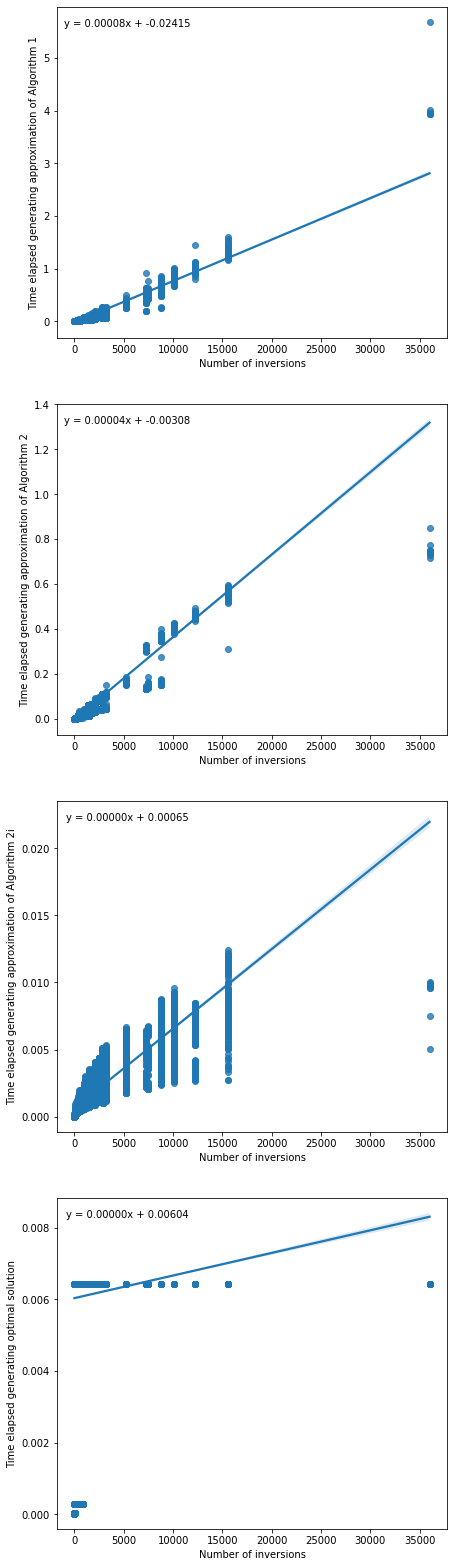

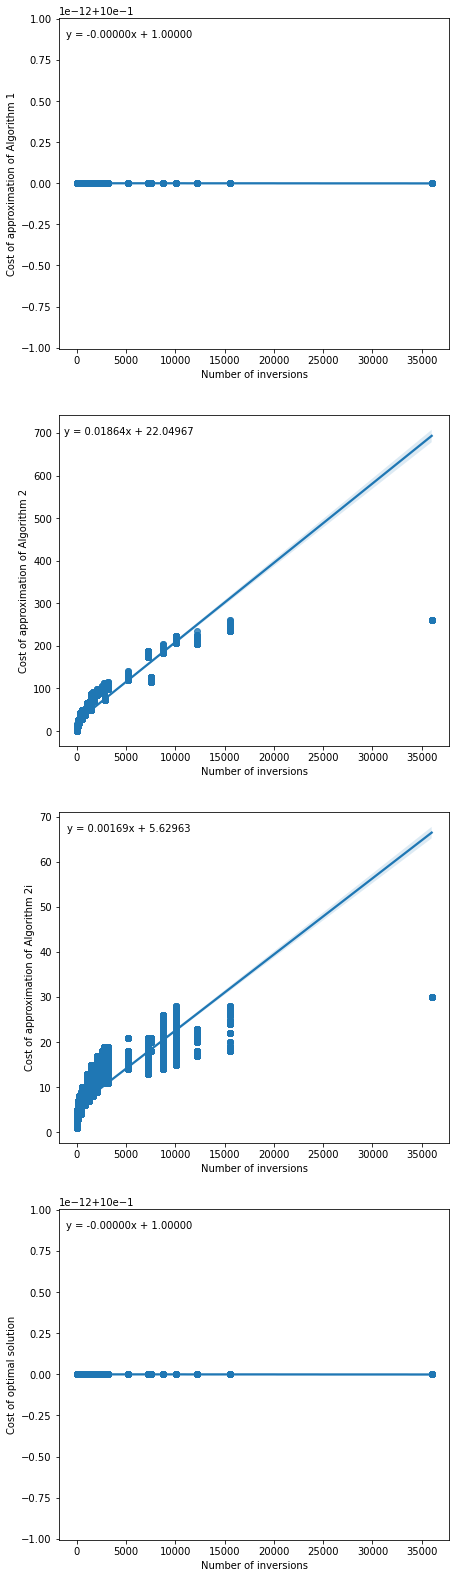

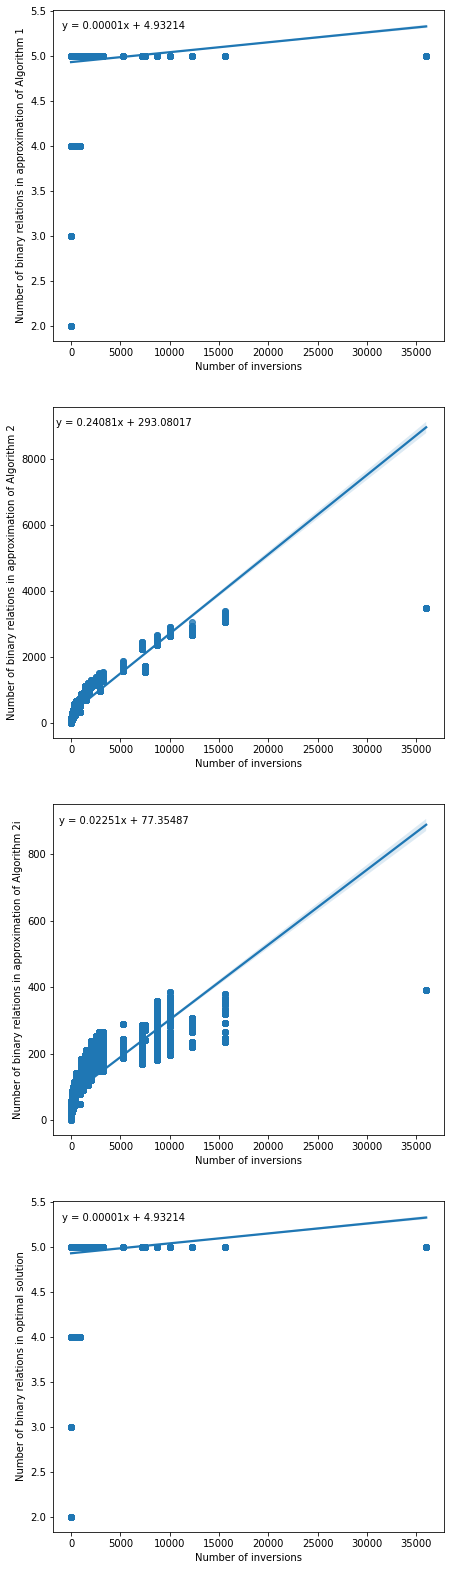

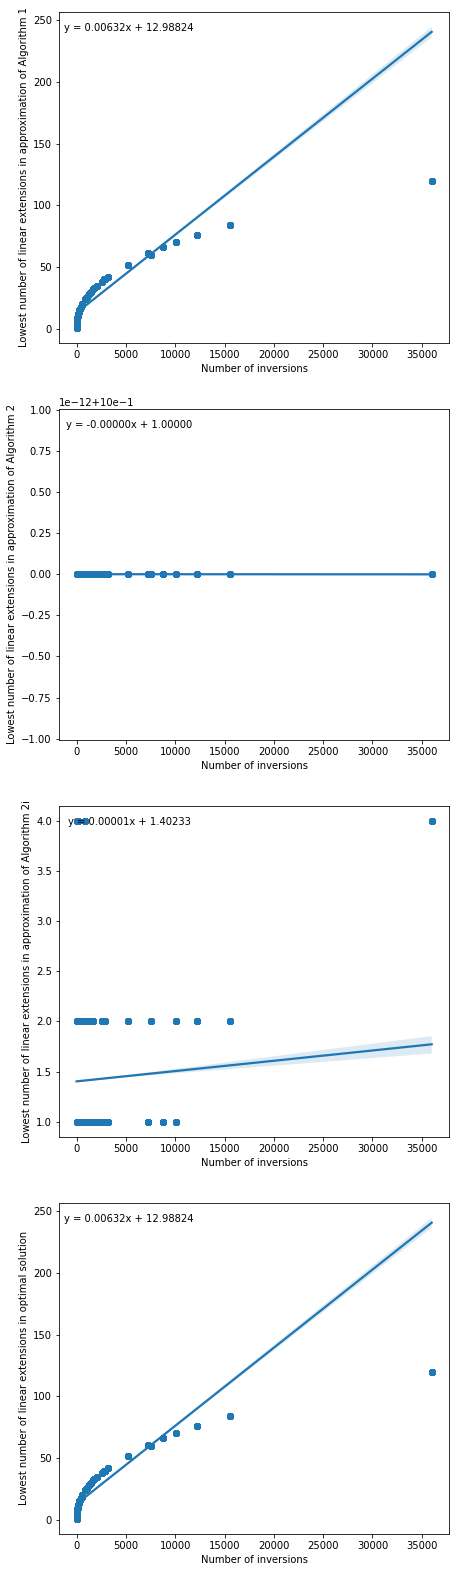

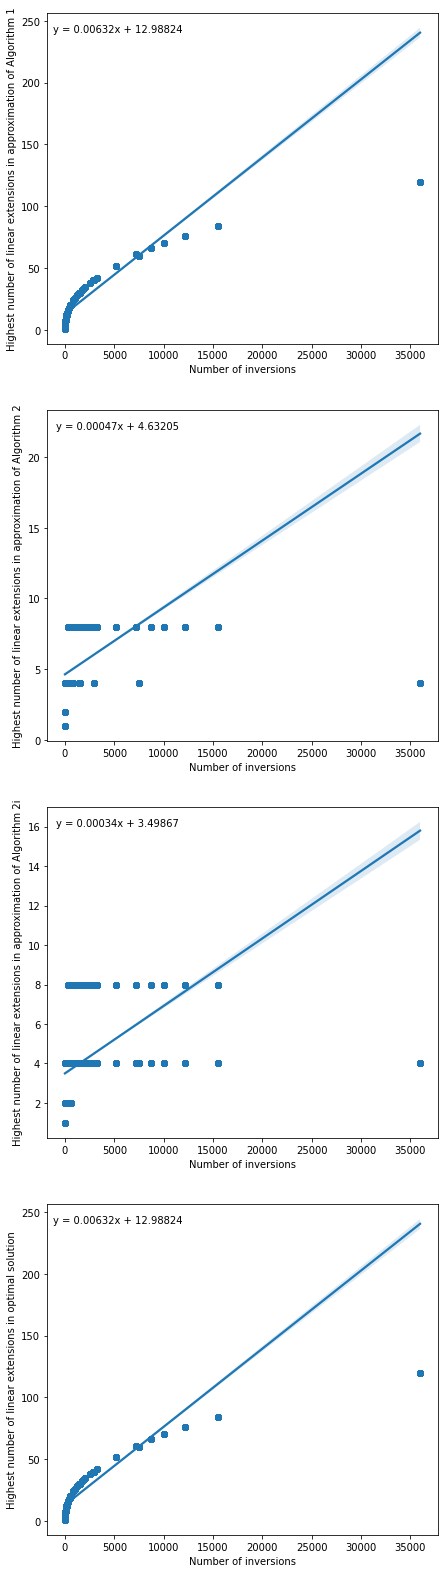

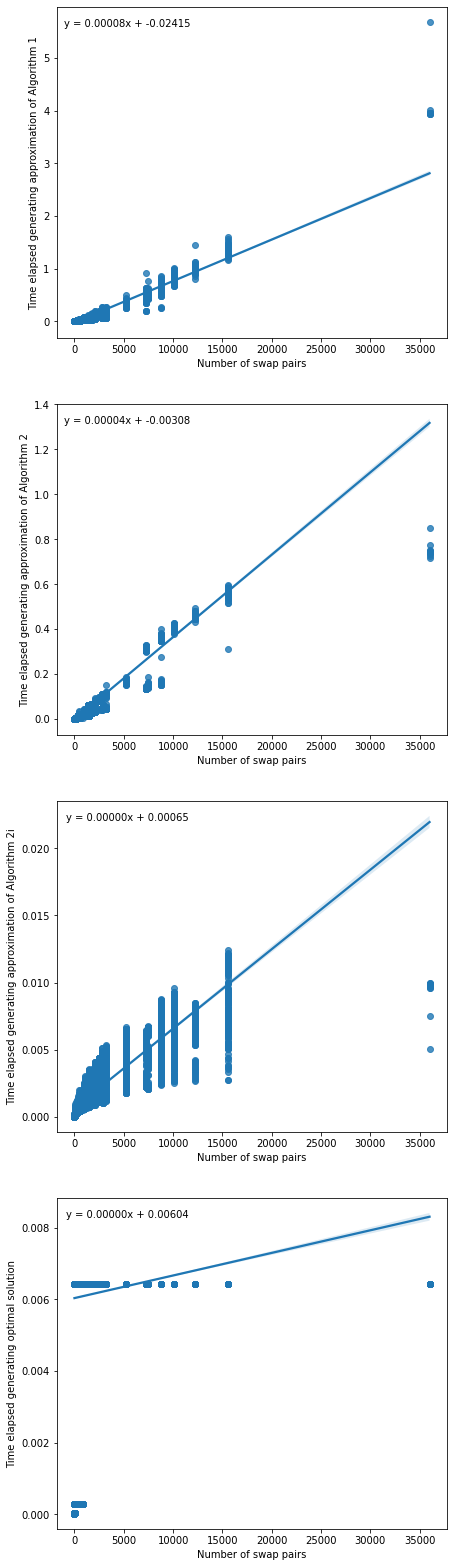

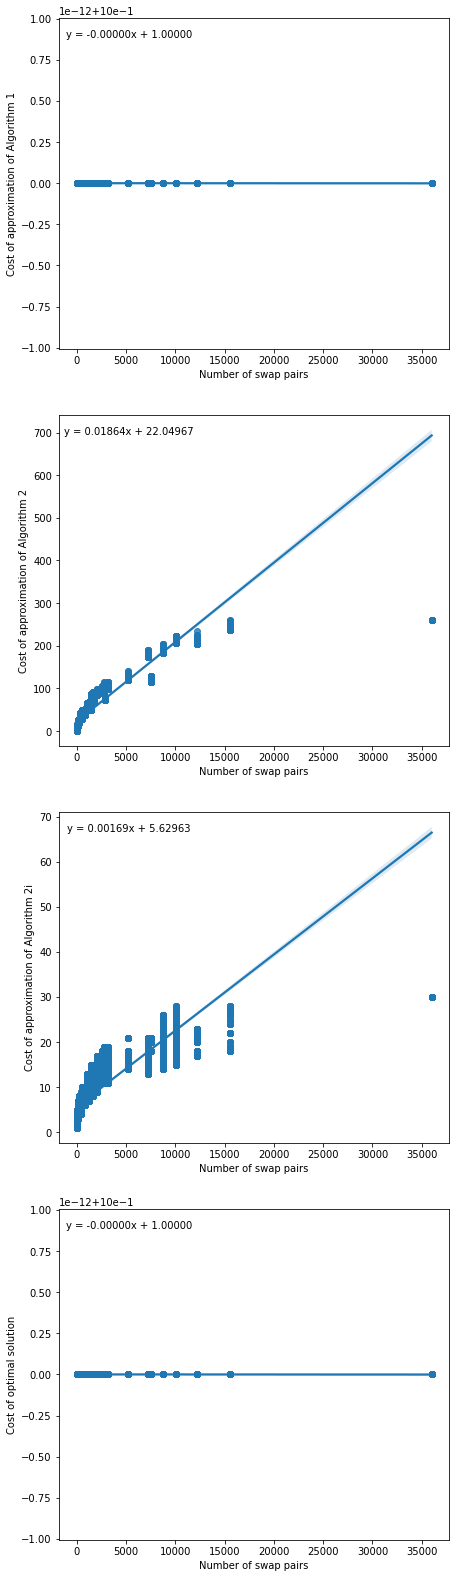

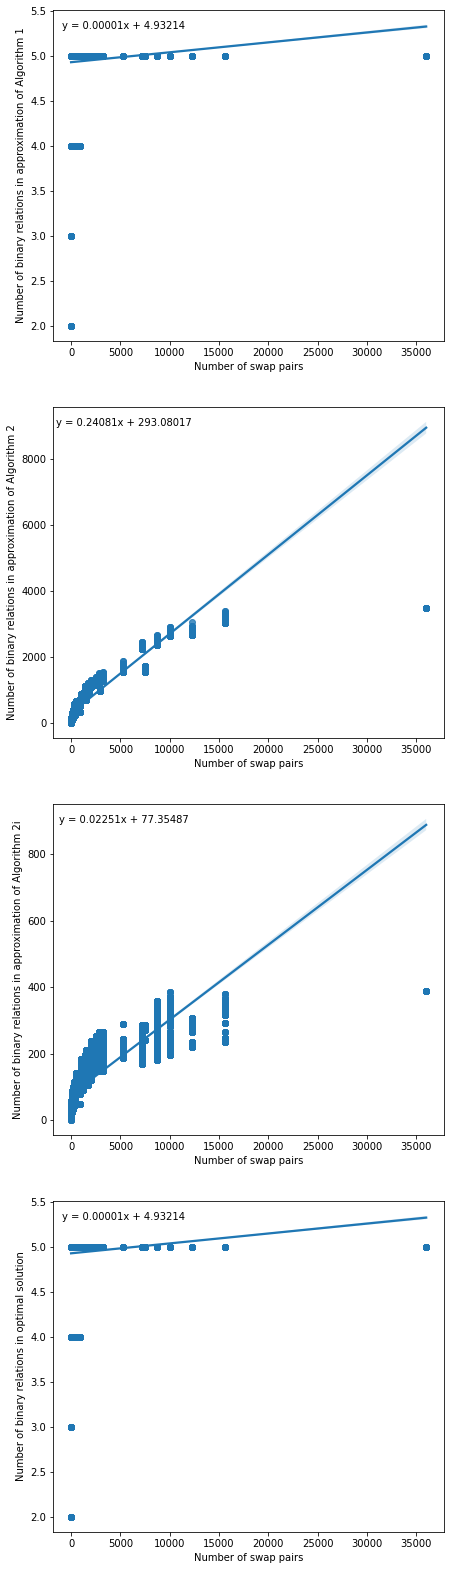

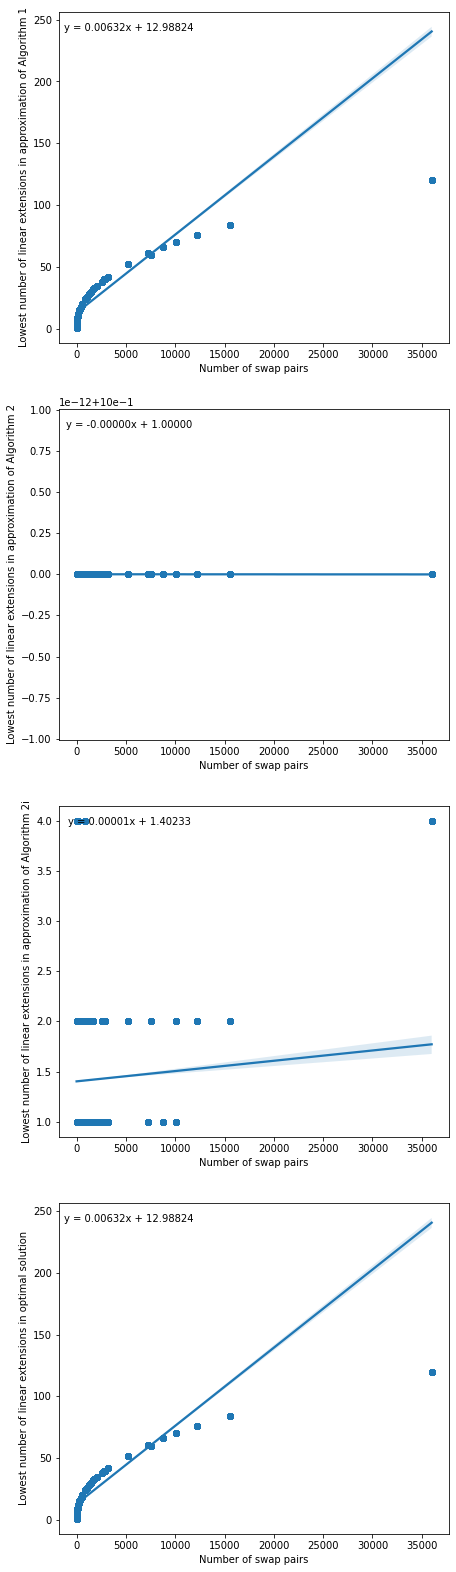

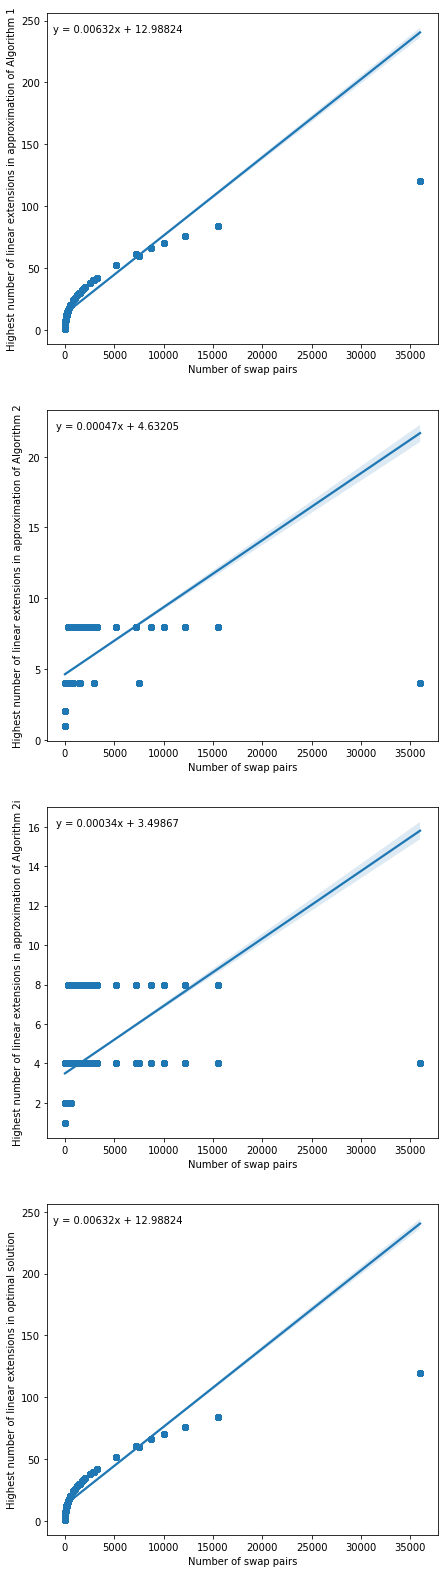

In [21]:
keywords = ['algo1', 'algo2', 'algo2i', 'optsol']
x_attributes = ['input_size', 'vertex_count', 'num_inversion', 'num_swap_pair']
y_attributes = ['runtime', 'cost', 'num_rel', 'min_lin_ext', 'max_lin_ext']
for x_attribute in x_attributes:
    for y_attribute in y_attributes:
        plotScatters(results_trees['all'], 
                     [x_attribute] + [f'{y_attribute}_{keyword}' for keyword in keywords],
                     'trees')

In [28]:
optapprox_trees = {}
keywords = ['algo1', 'algo2', 'algo2i']
for keyword in keywords:
    optapprox_trees[keyword] = getApproxVsVal(results_trees[keyword], keyword, 'cost_diff', 0)
    
for keyword in keywords:
    optapprox_algo = optapprox_trees[keyword]
    for vc in range(3, 7):
        print(optapprox_algo[optapprox_algo['vertex_count'] == vc].shape)
    print(optapprox_algo.shape)
    print('---')

(12, 14)
(128, 14)
(2000, 14)
(41472, 14)
(43612, 14)
---
(6, 14)
(24, 14)
(120, 14)
(720, 14)
(870, 14)
---
(12, 14)
(48, 14)
(270, 14)
(1620, 14)
(1950, 14)
---


In [29]:
nonoptapprox_trees = {}
keywords = ['algo1', 'algo2', 'algo2i']
for keyword in keywords:
    nonoptapprox_trees[keyword] = getApproxVsVal(results_trees[keyword], keyword, 'cost_diff', 0, 'neq')
    
for keyword in keywords:
    nonoptapprox_algo = nonoptapprox_trees[keyword]
    for vc in range(3, 7):
        print(nonoptapprox_algo[nonoptapprox_algo['vertex_count'] == vc].shape)
    print(nonoptapprox_algo.shape)
    print('---')

(0, 14)
(0, 14)
(0, 14)
(0, 14)
(0, 14)
---
(6, 14)
(104, 14)
(1880, 14)
(40752, 14)
(42742, 14)
---
(0, 14)
(80, 14)
(1730, 14)
(39852, 14)
(41662, 14)
---


In [33]:
sameapprox_trees = {}
keywords = ['algo1', 'algo2', 'algo2i']
for i in range(len(keywords)):
    for j in range(i + 1, len(keywords)):
        sameapprox_trees[f'{keywords[i]}_{keywords[j]}'] = getApproxVsApprox(results_trees['all'], 
                                                                             keywords[i], 
                                                                             keywords[j],
                                                                             'cost')
for key in sameapprox_trees.keys():
    print(f'{sameapprox_trees[key].shape} - {key}')

(870, 43) - algo1_algo2
(1950, 43) - algo1_algo2i
(870, 43) - algo2_algo2i


In [31]:
allv3trees = results_trees['all'][results_trees['all']['vertex_count'] == 3]
with pd.option_context('mode.chained_assignment', None):
    extendMore(allv3trees)
    
allv3trees[['input', 'is_opt_algo1', 'is_opt_algo2', 'is_opt_algo2i', 
            'cost_optsol', 'cost_algo1', 'cost_algo2', 'cost_algo2i']]

,input,is_opt_algo1,is_opt_algo2,is_opt_algo2i,cost_optsol,cost_algo1,cost_algo2,cost_algo2i
0,"[1, 2, 3]-[1, 3, 2]",True,False,True,1,1,2,1
1,"[3, 1, 2]",True,True,True,1,1,1,1
2,"[2, 1, 3]",True,True,True,1,1,1,1
3,"[2, 3, 1]-[3, 2, 1]",True,False,True,1,1,2,1
4,"[1, 2, 3]",True,True,True,1,1,1,1
5,"[1, 3, 2]-[3, 1, 2]",True,False,True,1,1,2,1
6,"[2, 1, 3]-[2, 3, 1]",True,False,True,1,1,2,1
7,"[3, 2, 1]",True,True,True,1,1,1,1
8,"[1, 3, 2]",True,True,True,1,1,1,1
9,"[1, 2, 3]-[2, 1, 3]",True,False,True,1,1,2,1


In [32]:
allv4trees = results_trees['all'][results_trees['all']['vertex_count'] == 4]
with pd.option_context('mode.chained_assignment', None):
    extendMore(allv4trees)
    
allv4trees[['input', 'is_opt_algo1', 'is_opt_algo2', 'is_opt_algo2i', 
            'cost_optsol', 'cost_algo1', 'cost_algo2', 'cost_algo2i']]

,input,is_opt_algo1,is_opt_algo2,is_opt_algo2i,cost_optsol,cost_algo1,cost_algo2,cost_algo2i
12,"[1, 2, 3, 4]-[1, 2, 4, 3]-[1, 3, 2, 4]-[1, 3, 4, 2]-[1, 4, 2, 3]-[1, 4, 3, 2]",True,False,False,1,1,7,3
13,"[4, 1, 2, 3]-[4, 1, 3, 2]",True,False,True,1,1,2,1
14,"[3, 1, 2, 4]-[3, 1, 4, 2]",True,False,True,1,1,2,1
15,"[3, 4, 1, 2]-[4, 3, 1, 2]",True,False,True,1,1,2,1
16,"[1, 2, 3, 4]-[1, 3, 2, 4]-[1, 3, 4, 2]",True,False,False,1,1,3,2
17,"[1, 2, 4, 3]-[1, 4, 2, 3]-[1, 4, 3, 2]-[4, 1, 2, 3]-[4, 1, 3, 2]",True,False,False,1,1,6,3
18,"[3, 1, 2, 4]-[3, 1, 4, 2]-[3, 4, 1, 2]",True,False,False,1,1,3,2
19,"[4, 3, 1, 2]",True,True,True,1,1,1,1
20,"[1, 2, 4, 3]-[1, 4, 2, 3]-[1, 4, 3, 2]",True,False,False,1,1,3,2
21,"[1, 2, 3, 4]-[1, 3, 2, 4]-[1, 3, 4, 2]-[3, 1, 2, 4]-[3, 1, 4, 2]",True,False,False,1,1,6,3
